<span style="color:red"><b>  생각해보기  </b></span>  <br>
* data에 outlier에 대해서도 해야하니 quantile regression 이 적합?? <br>
    -> probability 처럼 나타낼 수도 있음 <br>
    
    
* 바람 쌘 날이 잘 반영되지 않음 <br>
    -> 어떤 새로운 변수를 만들어야 하나??<br>
    
    
* TMA Capacity 정의 <br>
    TMA와 Aiport의 Capacity에 차이라고 한다면 holding으로 인한 것 뿐인 것 같음 <br>
    -> 이 부분만 airport capacity에 포함을 시키면 되지않을까? <br>
    
  
* 이 ML이 prediction이라고 주는 값은,  Demand가 ~고, 날씨가 ~일 떄 몇대가 들어올 것 같다는 값을 줌 <br>
    -> 이 항공기 숫자를 robust하게 예측하게 하고(확률적으로) reservior 개념을 적용해서 scheduling problem으로 발전(holding은 어떻게 넣을래?)  <br>
    
    
* 
<span style="color:red"> *** </span>
<b> reservoir를 하려면 AAR, ADR을 STAR, SID에 들어오는 수로 해야겠는데??? (특히 Arrival) </b> <br>
    그래야지 TMA용량 정의를 holding하는 항공기 수를 포함하여 적용가능<br>
    departure는 거의 공항과 같게 될 것 같음(departure는 홀딩을 거의 공항에서 하므로) , 아니면 departure로 hand off되는 고도에 도착하는 걸로
<br>
<br>
<br>
***
<br>    
<br>    
<br>
예를들어, reservoir에서 15분까지 airborne holding까지 허용한다고 하자 <br>
지금 방법으로하면 Demand만 한대씩 늘려가면서, 몇 대가 들어올 지 예측해서 값을 주는 거지 <br>
(즉, A대가 그떄 도착하도록 이렇게저렇게 GDP를 조정해서 보낸다 하면, 그 중 몇대가 B대가 그시간대에 올지 예측해서 값으로 줌) <br>
-> 이렇게 한대씩 늘렸을 때 예측값으로 준 rate과 불확실성을 대변하는 무엇(별표)을 가지고 최대 15분 holding이라는 기준을 맞추도록 stochastic scheduling을 해서 최종적으로 적절하게 보내도 되는 A값을 찾음 (여러 곳에서 오는 신호를 순서대로 처리하라고 보내는 것이라고 할 수도 있음)  <br>
-> A값을 그 상황에서의 Capacity 로 정의 <br>
<br>
<br>
<br>
별표 <br>
몇 대가 올지 예측한 거를 확률로?<br>
근데 어디서 올지, 언제 올지를 모른단 말이지 -> 이것도 확률로??<br>
***

# Data Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import optuna.integration.lightgbm as lgb          ####
from lightgbm import LGBMRegressor, plot_metric    #### 여기서 lgb로 안가져옴
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold

In [2]:
# options
pd.set_option('max_columns',100)
plt.style.use('fivethirtyeight')
warnings.simplefilter('ignore')
seed = 1

In [3]:
# Data dirctory
data_dir = Path('../data/')
data_file = data_dir / 'Data.csv'

In [4]:
# Data
# 0:AAR / 1:EAD / 2:ADR / 3:EDD는 고정  , 나머지는 순서 상관 없음
Data = pd.read_csv(data_file, index_col=0)
ColumnName = Data.columns
Data.head()

,AAR,EAD,ADR,EDD,year,month,day,hour,DayName,Arpt_cond,P_Airp,P_AAR,P_ADR,Arrival_remainder,Departure_remainder,WD_400,WD_500,WD_700,WD_850,WD_925,WD_1000,WS_400,WS_500,WS_700,WS_850,WS_925,WS_1000,WD,WSPD,WS_GST,VIS,WC,TMP,TD,PS,PA,RN,HM,CA_TOT,CLA_1LYR,BASE_1LYR,CLA_2LYR,BASE_2LYR,CLA_3LYR,BASE_3LYR,CLA_4LYR,BASE_4LYR,RVR,WDIR_t6,WSPD_t6,WG_t6,VIS_t6,WC_t6,CLA_1LYR_t6,BASE_1LYR_t6,CLA_2LYR_t6,BASE_2LYR_t6,CLA_3LYR_t6,BASE_3LYR_t6,WDIR_t12,WSPD_t12,WG_t12,VIS_t12,WC_t12,CLA_1LYR_t12,BASE_1LYR_t12,CLA_2LYR_t12,BASE_2LYR_t12,CLA_3LYR_t12,BASE_3LYR_t12,WDIR_t18,WSPD_t18,WG_t18,VIS_t18,WC_t18,CLA_1LYR_t18,BASE_1LYR_t18,CLA_2LYR_t18,BASE_2LYR_t18,CLA_3LYR_t18,BASE_3LYR_t18,WDIR_t24,WSPD_t24,WG_t24,VIS_t24,WC_t24,CLA_1LYR_t24,BASE_1LYR_t24,CLA_2LYR_t24,BASE_2LYR_t24,CLA_3LYR_t24,BASE_3LYR_t24
0,4.0,3.0,7.0,9.0,2019,1,1,0,2,1.0,1.0,0.0,0.0,0.0,0.0,275.0,265.0,245.0,280.0,280.0,305.0,96.0,80.0,31.0,12.0,23.0,8.0,1,6,0.0,1000,1,-53,-102,10359,10350,0.0,68,0,0.0,400.0,0.0,400.0,0.0,400.0,0.0,400.0,1000.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0
1,2.0,3.0,6.0,7.0,2019,1,1,1,2,1.0,1.0,4.0,7.0,0.0,2.0,275.0,265.0,245.0,280.0,280.0,305.0,96.0,80.0,31.0,12.0,23.0,8.0,31,5,0.0,1000,1,-57,-105,10358,10349,0.0,69,0,0.0,400.0,0.0,400.0,0.0,400.0,0.0,400.0,1000.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0
2,0.0,2.0,3.0,3.0,2019,1,1,2,2,1.0,1.0,2.0,6.0,1.0,1.0,275.0,265.0,245.0,280.0,280.0,305.0,96.0,80.0,31.0,12.0,23.0,8.0,33,4,0.0,1000,1,-60,-105,10359,10350,0.0,70,0,0.0,400.0,0.0,400.0,0.0,400.0,0.0,400.0,1000.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0
3,6.0,1.0,5.0,2.0,2019,1,1,3,2,1.0,1.0,0.0,3.0,2.0,0.0,275.0,265.0,245.0,280.0,280.0,305.0,96.0,80.0,31.0,12.0,23.0,8.0,32,4,0.0,1000,1,-63,-112,10363,10354,0.0,68,0,0.0,400.0,0.0,400.0,0.0,400.0,0.0,400.0,1000.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0
4,20.0,15.0,1.0,2.0,2019,1,1,4,2,1.0,1.0,6.0,5.0,0.0,0.0,275.0,265.0,245.0,280.0,280.0,305.0,96.0,80.0,31.0,12.0,23.0,8.0,7,1,0.0,1000,1,-66,-118,10357,10348,0.0,66,2,2.0,30.0,0.0,400.0,0.0,400.0,0.0,400.0,1000.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0,0.0,0.0,0.0,9999.0,0,0,400.0,0,400.0,0,400.0


***
***
***



# Data Preprocessing

In [ ]:
# Feature Scaling

# decision tree류의 알고리즘은 Scaling(standardization, normalization)이 큰 의미 X


"""
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
X = scaler.fit_transform(df[num_cols])
lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))

scaler = MinMaxScaler()
X = scaler.fit_transform(df[num_cols])
lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))
"""

In [ ]:
#Binning

#어떤 feature를 n개의 그룹으로 나누고, 그것을 새로운 categorical data로 넣는 것

"""
df['time_bin'] = pd.qcut(df['time'], 4, labels=False)
sns.pairplot(data=df, vars=['time', 'time_bin'], size=4, plot_kws={'alpha': .5})


X = pd.concat([df[num_cols], pd.get_dummies(pd.qcut(df['time'], 4, labels=False))], axis=1)    
# get_dummies 는 one-hot encoding해주는 것(decision tree 계열을 안 하는게 보통 더 좋은 결과를 냄)

lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))
"""

In [ ]:
# Polynomial Regression

# 연속적인 몇개의 feature들을 조합해서 새로운 feature를 만드는 것 (overfitting 위험 O)

"""
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)        # 2차(x^2, x1 * x2 등) 까지만 만들겠다
X = poly.fit_transform(df[num_cols])

lr = LinearRegression()
lr.fit(X, np.log1p(df[target_col]))
df[pred_col] = np.expm1(lr.predict(X))
"""

In [ ]:
# Checking for NaN values and removing constant features in the training data
# Removing duplicated columns
# Drop Sparse Data

### Add Features
# Sumzeros and Sumvalues
# Other Aggregates
# K-Means
# PCA : Principal component analysis



***
***
***

# Data Selection

In [5]:
# 필요없는 것을 버리기
Data_temp = Data.drop('TMP', axis=1)
Data_temp = Data_temp.drop('TD', axis=1)
Data_temp = Data_temp.drop('HM', axis=1)
Data_temp = Data_temp.drop('PS', axis=1)
Data_temp = Data_temp.drop('PA', axis=1)

######## 고층바람이 생각보다 영향이 크다?? -> 너무 높은 고도는 뺴고 해보자  ########
Data_temp = Data_temp.drop('WD_400', axis=1)
Data_temp = Data_temp.drop('WD_500', axis=1)
Data_temp = Data_temp.drop('WD_700', axis=1)
Data_temp = Data_temp.drop('WS_400', axis=1)
Data_temp = Data_temp.drop('WS_500', axis=1)
Data_temp = Data_temp.drop('WS_700', axis=1)

# drop TAF
for i in range(6,30,6):
    Data_temp = Data_temp.drop(f'WDIR_t{i}', axis=1)
    Data_temp = Data_temp.drop(f'WSPD_t{i}', axis=1)
    Data_temp = Data_temp.drop(f'WG_t{i}', axis=1)
    Data_temp = Data_temp.drop(f'VIS_t{i}', axis=1)
    Data_temp = Data_temp.drop(f'WC_t{i}', axis=1)
    Data_temp = Data_temp.drop(f'CLA_1LYR_t{i}', axis=1)
    Data_temp = Data_temp.drop(f'BASE_1LYR_t{i}', axis=1)
    Data_temp = Data_temp.drop(f'CLA_2LYR_t{i}', axis=1)
    Data_temp = Data_temp.drop(f'BASE_2LYR_t{i}', axis=1)
    Data_temp = Data_temp.drop(f'CLA_3LYR_t{i}', axis=1)
    Data_temp = Data_temp.drop(f'BASE_3LYR_t{i}', axis=1)

In [6]:
# 각 시간에 맞는 TAF로 나누기
taf6 = [12,18,24]
taf12 = [6,18,24]
taf18 = [6,12,24]
taf24 = [6,12,18]
    
# 각 시간에 맞는 taf 넣기
data_taf = {}
for i in range(6,30,6):
    data_taf[f'Data_{i}'] = Data_temp    
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'WDIR_t{i}'])
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'WSPD_t{i}'])
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'WG_t{i}'])
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'VIS_t{i}'])
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'WC_t{i}'])
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'CLA_1LYR_t{i}'])
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'BASE_1LYR_t{i}'])
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'CLA_2LYR_t{i}'])
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'BASE_2LYR_t{i}'])
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'CLA_3LYR_t{i}'])
    data_taf[f'Data_{i}'] = data_taf[f'Data_{i}'].join(Data[f'BASE_3LYR_t{i}'])
    
Data_6 = data_taf['Data_6']
Data_12 = data_taf['Data_12']
Data_18 = data_taf['Data_18']
Data_24 = data_taf['Data_24']

Validation <br><br>

sklearn.model_selection
* train_test_split
* KFold
* StratifiedKFold

<br>
<br>
lightGBM <br>
* lgb.cv    # 쓰려면 lightgbm을 lgb로 import

***
***
***

# LightGBM fitting

In [7]:
# Hyperparameters
params = {'boosting_type' : 'gbdt',            # 'dart' 는 계산시간 길어짐, early stopping X / 'rf’ : Random Forest
          'metric': 'mse',
          'num_leaves' : 127,                  ## Maximum tree leaves for base learners (31)
          'max_depth' : - 1,                   # Maximum tree depth for base learners, <=0 means no limit (-1)
          'learning_rate' : 0.001,             ## Boosting learning rate (0.1)
          'n_estimators' : 10000000,           # Number of boosted trees to fit (100) -> fit에서 early stopping으로 제한해서 크게 설정함
          'subsample_for_bin' : 200000,        # Number of samples for constructing bins (200000)
          'objective' : 'regression',          # learning task and the corresponding learning objective (None)
          'class_weight' : None,               # * Use this parameter only for multi-class classification task
          'min_split_gain' : 0.0,              # Minimum loss reduction required to make a further partition on a leaf node of the tree (0)
          'min_child_weight' : 0.001,          # Minimum sum of instance weight (hessian) needed in a child (leaf) (0.001)
          'min_child_samples' : 1,             # Minimum number of data needed in a child (leaf) (20) - 마지막노드(리프)에 최소 몇가지 샘플이 있어야 하는지 
          'subsample' : 0.8,                   ## Subsample ratio of the training instance (1.0) - 개별 트리를 학습시키는데 몇 %의 데이터를 사용할 것 인지, row sampling
          'subsample_freq' : 1,                # Frequency of subsample, <=0 means no enable (0) - 몇개의 트리마다 subsampling을 할 것인지
          'colsample_bytree' : 0.8,            ## Subsample ratio of columns when constructing each tree (1.0) - 몇 %의 column을 sampling 할 것인지
          'reg_alpha' : 0.0,                   # L1 regularization term on weights (0)
          'reg_lambda' : 0.0,                  # L2 regularization term on weights (0)
          'random_state' : seed,               # Random number seed (None)
          'n_jobs' : - 1,                      # Number of parallel threads (-1) - 몇 개의 병렬작업을 할 것인지 (-1 = 모든 가능한 것 전부)
          'silent' : True,                     # Whether to print messages while running boosting (True)
          'importance_type' : 'split'}         # ‘split’: result contains numbers of times the feature is used in a model
                                               # ‘gain’ : result contains total gains of splits which use the feature

# 최적 hyperparameter 찾기!!

In [8]:
# Hyperparameters
params_a = {'boosting_type' : 'gbdt',                   # 'dart' 는 계산시간 길어짐, early stopping X / 'rf’ : Random Forest
            'metric': 'mse',
            'num_leaves' : 127,                          ## Maximum tree leaves for base learners (31)
            'max_depth' : - 1,                          # Maximum tree depth for base learners, <=0 means no limit (-1)
            'learning_rate' : 0.001,                    ## Boosting learning rate (0.1)
            'n_estimators' : 10000000,                  # Number of boosted trees to fit (100) -> fit에서 early stopping으로 제한해서 크게 설정함
            'subsample_for_bin' : 200000,               # Number of samples for constructing bins (200000)
            'objective' : 'regression',                 # learning task and the corresponding learning objective (None)
            'class_weight' : None,                      # * Use this parameter only for multi-class classification task
            'min_split_gain' : 0.0,                     # Minimum loss reduction required to make a further partition on a leaf node of the tree (0)
            'min_child_weight' : 0.001,                 # Minimum sum of instance weight (hessian) needed in a child (leaf) (0.001)
            'min_child_samples' : 1,                    # Minimum number of data needed in a child (leaf) (20) - 마지막노드(리프)에 최소 몇가지 샘플이 있어야 하는지 
            'feature_pre_filter': False,
            'subsample' : 0.8941758297667703,           ## Subsample ratio of the training instance (1.0) - 개별 트리를 학습시키는데 몇 %의 데이터를 사용할 것 인지, row sampling
            'subsample_freq' : 1,   #3                  # Frequency of subsample, <=0 means no enable (0) - 몇개의 트리마다 subsampling을 할 것인지
            'colsample_bytree' : 0.7520000000000001,    ## Subsample ratio of columns when constructing each tree (1.0) - 몇 %의 column을 sampling 할 것인지
            'reg_alpha' : 0.00010798877450667029,       # L1 regularization term on weights (0)
            'reg_lambda' : 0.572291122965791,           # L2 regularization term on weights (0)
            'random_state' : seed,                      # Random number seed (None)
            'n_jobs' : - 1,                             # Number of parallel threads (-1) - 몇 개의 병렬작업을 할 것인지 (-1 = 모든 가능한 것 전부)
            'silent' : True,                            # Whether to print messages while running boosting (True)
            'importance_type' : 'split'}                # ‘split’: result contains numbers of times the feature is used in a model
                                                        # ‘gain’ : result contains total gains of splits which use the feature

In [9]:
# Hyperparameters
params_d = {'boosting_type' : 'gbdt',                 # 'dart' 는 계산시간 길어짐, early stopping X / 'rf’ : Random Forest
            'metric': 'mse',
            'num_leaves' : 127,                        ## Maximum tree leaves for base learners (31)
            'max_depth' : - 1,                        # Maximum tree depth for base learners, <=0 means no limit (-1)
            'learning_rate' : 0.001,                  ## Boosting learning rate (0.1)
            'n_estimators' : 10000000,                # Number of boosted trees to fit (100) -> fit에서 early stopping으로 제한해서 크게 설정함
            'subsample_for_bin' : 200000,             # Number of samples for constructing bins (200000)
            'objective' : 'regression',               # learning task and the corresponding learning objective (None)
            'class_weight' : None,                    # * Use this parameter only for multi-class classification task
            'min_split_gain' : 0.0,                   # Minimum loss reduction required to make a further partition on a leaf node of the tree (0)
            'min_child_weight' : 0.001,               # Minimum sum of instance weight (hessian) needed in a child (leaf) (0.001)
            'min_child_samples' : 1,                  # Minimum number of data needed in a child (leaf) (20) - 마지막노드(리프)에 최소 몇가지 샘플이 있어야 하는지 
            'feature_pre_filter': False,
            'subsample' : 0.8862849544828171,         ## Subsample ratio of the training instance (1.0) - 개별 트리를 학습시키는데 몇 %의 데이터를 사용할 것 인지, row sampling
            'subsample_freq' : 1,    #3               # Frequency of subsample, <=0 means no enable (0) - 몇개의 트리마다 subsampling을 할 것인지
            'colsample_bytree' : 0.7,                 ## Subsample ratio of columns when constructing each tree (1.0) - 몇 %의 column을 sampling 할 것인지
            'reg_alpha' : 3.2041046397019426e-05,     # L1 regularization term on weights (0)
            'reg_lambda' : 2.4947477155359143e-05,    # L2 regularization term on weights (0)
            'random_state' : seed,                    # Random number seed (None)
            'n_jobs' : - 1,                           # Number of parallel threads (-1) - 몇 개의 병렬작업을 할 것인지 (-1 = 모든 가능한 것 전부)
            'silent' : True,                          # Whether to print messages while running boosting (True)
            'importance_type' : 'split'}              # ‘split’: result contains numbers of times the feature is used in a model
                                                      # ‘gain’ : result contains total gains of splits which use the feature

In [10]:
# 예측할 시간에 맞는 Data로 넣기
# 0-6 : Data_6 / 6-12 : Data_12 / 12-18 : Data_18 / 18-24 : Data_24
Data_raw = Data_6
Data_m = Data_6
Data_m = Data_m.drop('AAR', axis=1)
Data_m = Data_m.drop('ADR', axis=1)

***
## Hyperparameter Optimization

In [ ]:
# Optuna 간단 버전 - arrival

"""

Data_a = Data_m.drop('AAR', axis=1)
y = Data_raw.AAR.to_numpy()
X = Data_a.to_numpy()

X_train_a, X_val_a, y_train_a, y_val_a = train_test_split(X, y, test_size=.2, random_state=seed)

dtrain_a = lgb.Dataset(X_train_a, label = y_train_a)
dval_a = lgb.Dataset(X_val_a, label = y_val_a)

model = lgb.train(params, dtrain_a,
                  valid_sets=[dtrain_a, dval_a], 
                  verbose_eval=100,
                  early_stopping_rounds=10)

prediction = model.predict(X_val_a, num_iteration=model.best_iteration)

accuracy = r2_score(y_val_a, prediction)        # classification이면 앞에 argmax( , axis = 1)로 하면 될 듯



params = model.params
print("Best params:", params)
print("  Accuracy = {}".format(accuracy))o
print("  Params: ")
for key, value in params.items():
    print("    {}: {}".format(key, value))

params_a = params

"""

In [ ]:
# Optuna 간단 버전 - departure

"""

Data_d = Data_m.drop('ADR', axis=1)
y = Data_raw.ADR.to_numpy()
X = Data_d.to_numpy()

X_train_d, X_val_d, y_train_d, y_val_d = train_test_split(X, y, test_size=.2, random_state=seed)

dtrain_d = lgb.Dataset(X_train_d, label = y_train_d)
dval_d = lgb.Dataset(X_val_d, label = y_val_d)

model = lgb.train(params, dtrain_d,
                  valid_sets=[dtrain_d, dval_d], 
                  verbose_eval=100,
                  early_stopping_rounds=10)

prediction = model.predict(X_val_d, num_iteration=model.best_iteration)

accuracy = r2_score(y_val_d, prediction)         # classification이면 앞에 argmax( , axis = 1)로 하면 될 듯

params = model.params
print("Best params:", params)
print("  Accuracy = {}".format(accuracy))
print("  Params: ")
for key, value in params.items():
    print("    {}: {}".format(key, value))

params_d = params

"""

***
## Arrival

In [11]:
y = Data_raw.AAR.to_numpy()
X = Data_m.to_numpy()

#X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X, y, test_size = 0.1, random_state = seed)
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X, y, test_size = 0.1, random_state = seed)
X_train_a, X_val_a, y_train_a, y_val_a = train_test_split(X_train_a, y_train_a, test_size=0.11, random_state = 13) 
# 0.11 x 0.9 = 0.099

In [12]:
# Model fitting
reg_arrival = LGBMRegressor(**params_a)

reg_arrival.fit(X_train_a, y_train_a,
                sample_weight = None,                   # Weights of training data
                init_score = None,                      # Weights of training data
                eval_set = [(X_val_a, y_val_a)],        # pairs to use as validation sets
                eval_sample_weight = None,              # Weights of eval data
                eval_init_score = None,                 # Init score of eval data.   
                eval_metric = 'l2',                     # Default: ‘l2’ for LGBMRegressor, ‘logloss’ for LGBMClassifier
                early_stopping_rounds = 10 )            # loss fuction이 n번 이상 좋아지지 않으면 멈춰라

[1]	valid_0's l2: 127.798
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 127.559
[3]	valid_0's l2: 127.319
[4]	valid_0's l2: 127.082
[5]	valid_0's l2: 126.845
[6]	valid_0's l2: 126.608
[7]	valid_0's l2: 126.379
[8]	valid_0's l2: 126.143
[9]	valid_0's l2: 125.909
[10]	valid_0's l2: 125.674
[11]	valid_0's l2: 125.44
[12]	valid_0's l2: 125.206
[13]	valid_0's l2: 124.972
[14]	valid_0's l2: 124.74
[15]	valid_0's l2: 124.506
[16]	valid_0's l2: 124.28
[17]	valid_0's l2: 124.049
[18]	valid_0's l2: 123.817
[19]	valid_0's l2: 123.591
[20]	valid_0's l2: 123.365
[21]	valid_0's l2: 123.136
[22]	valid_0's l2: 122.907
[23]	valid_0's l2: 122.678
[24]	valid_0's l2: 122.451
[25]	valid_0's l2: 122.222
[26]	valid_0's l2: 121.994
[27]	valid_0's l2: 121.767
[28]	valid_0's l2: 121.544
[29]	valid_0's l2: 121.32
[30]	valid_0's l2: 121.094
[31]	valid_0's l2: 120.869
[32]	valid_0's l2: 120.645
[33]	valid_0's l2: 120.42
[34]	valid_0's l2: 120.201
[35]	valid_0's l2: 119.977
[36]	val

[300]	valid_0's l2: 74.6101
[301]	valid_0's l2: 74.4766
[302]	valid_0's l2: 74.3433
[303]	valid_0's l2: 74.2141
[304]	valid_0's l2: 74.0822
[305]	valid_0's l2: 73.9504
[306]	valid_0's l2: 73.8191
[307]	valid_0's l2: 73.6921
[308]	valid_0's l2: 73.5629
[309]	valid_0's l2: 73.4311
[310]	valid_0's l2: 73.3057
[311]	valid_0's l2: 73.176
[312]	valid_0's l2: 73.0451
[313]	valid_0's l2: 72.9176
[314]	valid_0's l2: 72.7886
[315]	valid_0's l2: 72.6603
[316]	valid_0's l2: 72.5319
[317]	valid_0's l2: 72.4015
[318]	valid_0's l2: 72.2731
[319]	valid_0's l2: 72.1437
[320]	valid_0's l2: 72.0162
[321]	valid_0's l2: 71.8901
[322]	valid_0's l2: 71.7629
[323]	valid_0's l2: 71.6365
[324]	valid_0's l2: 71.5091
[325]	valid_0's l2: 71.3814
[326]	valid_0's l2: 71.2588
[327]	valid_0's l2: 71.1322
[328]	valid_0's l2: 71.0054
[329]	valid_0's l2: 70.8792
[330]	valid_0's l2: 70.7545
[331]	valid_0's l2: 70.6297
[332]	valid_0's l2: 70.5045
[333]	valid_0's l2: 70.3791
[334]	valid_0's l2: 70.2561
[335]	valid_0's l2: 7

[594]	valid_0's l2: 45.2344
[595]	valid_0's l2: 45.1594
[596]	valid_0's l2: 45.0845
[597]	valid_0's l2: 45.0092
[598]	valid_0's l2: 44.9361
[599]	valid_0's l2: 44.8609
[600]	valid_0's l2: 44.7866
[601]	valid_0's l2: 44.7137
[602]	valid_0's l2: 44.6402
[603]	valid_0's l2: 44.5682
[604]	valid_0's l2: 44.4956
[605]	valid_0's l2: 44.4224
[606]	valid_0's l2: 44.3488
[607]	valid_0's l2: 44.2759
[608]	valid_0's l2: 44.2042
[609]	valid_0's l2: 44.1339
[610]	valid_0's l2: 44.0624
[611]	valid_0's l2: 43.9894
[612]	valid_0's l2: 43.9175
[613]	valid_0's l2: 43.8477
[614]	valid_0's l2: 43.775
[615]	valid_0's l2: 43.702
[616]	valid_0's l2: 43.6318
[617]	valid_0's l2: 43.5596
[618]	valid_0's l2: 43.4887
[619]	valid_0's l2: 43.417
[620]	valid_0's l2: 43.348
[621]	valid_0's l2: 43.2769
[622]	valid_0's l2: 43.2074
[623]	valid_0's l2: 43.1365
[624]	valid_0's l2: 43.0663
[625]	valid_0's l2: 42.9971
[626]	valid_0's l2: 42.9266
[627]	valid_0's l2: 42.8557
[628]	valid_0's l2: 42.7856
[629]	valid_0's l2: 42.7

[900]	valid_0's l2: 28.1298
[901]	valid_0's l2: 28.0886
[902]	valid_0's l2: 28.048
[903]	valid_0's l2: 28.0072
[904]	valid_0's l2: 27.9664
[905]	valid_0's l2: 27.9263
[906]	valid_0's l2: 27.8859
[907]	valid_0's l2: 27.8455
[908]	valid_0's l2: 27.8057
[909]	valid_0's l2: 27.7651
[910]	valid_0's l2: 27.7249
[911]	valid_0's l2: 27.684
[912]	valid_0's l2: 27.6437
[913]	valid_0's l2: 27.6102
[914]	valid_0's l2: 27.5696
[915]	valid_0's l2: 27.5412
[916]	valid_0's l2: 27.5007
[917]	valid_0's l2: 27.4618
[918]	valid_0's l2: 27.4209
[919]	valid_0's l2: 27.3805
[920]	valid_0's l2: 27.3408
[921]	valid_0's l2: 27.3026
[922]	valid_0's l2: 27.2639
[923]	valid_0's l2: 27.2244
[924]	valid_0's l2: 27.1859
[925]	valid_0's l2: 27.1474
[926]	valid_0's l2: 27.1092
[927]	valid_0's l2: 27.0756
[928]	valid_0's l2: 27.036
[929]	valid_0's l2: 26.997
[930]	valid_0's l2: 26.958
[931]	valid_0's l2: 26.9193
[932]	valid_0's l2: 26.8811
[933]	valid_0's l2: 26.8435
[934]	valid_0's l2: 26.8045
[935]	valid_0's l2: 26.76

[1194]	valid_0's l2: 19.0235
[1195]	valid_0's l2: 19.0003
[1196]	valid_0's l2: 18.9766
[1197]	valid_0's l2: 18.9532
[1198]	valid_0's l2: 18.9317
[1199]	valid_0's l2: 18.909
[1200]	valid_0's l2: 18.8866
[1201]	valid_0's l2: 18.8641
[1202]	valid_0's l2: 18.8404
[1203]	valid_0's l2: 18.8173
[1204]	valid_0's l2: 18.7948
[1205]	valid_0's l2: 18.7721
[1206]	valid_0's l2: 18.7491
[1207]	valid_0's l2: 18.7264
[1208]	valid_0's l2: 18.7034
[1209]	valid_0's l2: 18.6807
[1210]	valid_0's l2: 18.6575
[1211]	valid_0's l2: 18.635
[1212]	valid_0's l2: 18.6133
[1213]	valid_0's l2: 18.5909
[1214]	valid_0's l2: 18.5681
[1215]	valid_0's l2: 18.5457
[1216]	valid_0's l2: 18.5241
[1217]	valid_0's l2: 18.5028
[1218]	valid_0's l2: 18.4801
[1219]	valid_0's l2: 18.4583
[1220]	valid_0's l2: 18.4364
[1221]	valid_0's l2: 18.4144
[1222]	valid_0's l2: 18.393
[1223]	valid_0's l2: 18.3704
[1224]	valid_0's l2: 18.3482
[1225]	valid_0's l2: 18.326
[1226]	valid_0's l2: 18.3045
[1227]	valid_0's l2: 18.2821
[1228]	valid_0's l

[1487]	valid_0's l2: 13.9095
[1488]	valid_0's l2: 13.8966
[1489]	valid_0's l2: 13.8829
[1490]	valid_0's l2: 13.8703
[1491]	valid_0's l2: 13.8582
[1492]	valid_0's l2: 13.8454
[1493]	valid_0's l2: 13.8321
[1494]	valid_0's l2: 13.8194
[1495]	valid_0's l2: 13.8059
[1496]	valid_0's l2: 13.7927
[1497]	valid_0's l2: 13.7792
[1498]	valid_0's l2: 13.766
[1499]	valid_0's l2: 13.7528
[1500]	valid_0's l2: 13.7401
[1501]	valid_0's l2: 13.7272
[1502]	valid_0's l2: 13.714
[1503]	valid_0's l2: 13.7018
[1504]	valid_0's l2: 13.6889
[1505]	valid_0's l2: 13.6764
[1506]	valid_0's l2: 13.6636
[1507]	valid_0's l2: 13.6512
[1508]	valid_0's l2: 13.6383
[1509]	valid_0's l2: 13.6259
[1510]	valid_0's l2: 13.6132
[1511]	valid_0's l2: 13.6002
[1512]	valid_0's l2: 13.5874
[1513]	valid_0's l2: 13.5746
[1514]	valid_0's l2: 13.5623
[1515]	valid_0's l2: 13.5496
[1516]	valid_0's l2: 13.5371
[1517]	valid_0's l2: 13.5243
[1518]	valid_0's l2: 13.5117
[1519]	valid_0's l2: 13.4992
[1520]	valid_0's l2: 13.487
[1521]	valid_0's 

[1771]	valid_0's l2: 11.0494
[1772]	valid_0's l2: 11.041
[1773]	valid_0's l2: 11.0335
[1774]	valid_0's l2: 11.0255
[1775]	valid_0's l2: 11.0183
[1776]	valid_0's l2: 11.0103
[1777]	valid_0's l2: 11.0026
[1778]	valid_0's l2: 10.9954
[1779]	valid_0's l2: 10.9877
[1780]	valid_0's l2: 10.9799
[1781]	valid_0's l2: 10.9721
[1782]	valid_0's l2: 10.9647
[1783]	valid_0's l2: 10.957
[1784]	valid_0's l2: 10.9495
[1785]	valid_0's l2: 10.9422
[1786]	valid_0's l2: 10.9348
[1787]	valid_0's l2: 10.9273
[1788]	valid_0's l2: 10.9197
[1789]	valid_0's l2: 10.9123
[1790]	valid_0's l2: 10.9055
[1791]	valid_0's l2: 10.8987
[1792]	valid_0's l2: 10.8906
[1793]	valid_0's l2: 10.883
[1794]	valid_0's l2: 10.8757
[1795]	valid_0's l2: 10.8678
[1796]	valid_0's l2: 10.8608
[1797]	valid_0's l2: 10.8534
[1798]	valid_0's l2: 10.8461
[1799]	valid_0's l2: 10.8392
[1800]	valid_0's l2: 10.8324
[1801]	valid_0's l2: 10.8252
[1802]	valid_0's l2: 10.8196
[1803]	valid_0's l2: 10.8123
[1804]	valid_0's l2: 10.8059
[1805]	valid_0's 

[2056]	valid_0's l2: 9.36676
[2057]	valid_0's l2: 9.36234
[2058]	valid_0's l2: 9.35819
[2059]	valid_0's l2: 9.35357
[2060]	valid_0's l2: 9.34964
[2061]	valid_0's l2: 9.34646
[2062]	valid_0's l2: 9.34195
[2063]	valid_0's l2: 9.33729
[2064]	valid_0's l2: 9.33308
[2065]	valid_0's l2: 9.33005
[2066]	valid_0's l2: 9.32545
[2067]	valid_0's l2: 9.32071
[2068]	valid_0's l2: 9.31648
[2069]	valid_0's l2: 9.31199
[2070]	valid_0's l2: 9.30774
[2071]	valid_0's l2: 9.30311
[2072]	valid_0's l2: 9.29882
[2073]	valid_0's l2: 9.29446
[2074]	valid_0's l2: 9.2902
[2075]	valid_0's l2: 9.28611
[2076]	valid_0's l2: 9.28179
[2077]	valid_0's l2: 9.27718
[2078]	valid_0's l2: 9.27317
[2079]	valid_0's l2: 9.26877
[2080]	valid_0's l2: 9.26433
[2081]	valid_0's l2: 9.26094
[2082]	valid_0's l2: 9.25649
[2083]	valid_0's l2: 9.25299
[2084]	valid_0's l2: 9.24872
[2085]	valid_0's l2: 9.24462
[2086]	valid_0's l2: 9.24044
[2087]	valid_0's l2: 9.23599
[2088]	valid_0's l2: 9.23161
[2089]	valid_0's l2: 9.22739
[2090]	valid_0'

[2362]	valid_0's l2: 8.33667
[2363]	valid_0's l2: 8.33399
[2364]	valid_0's l2: 8.33172
[2365]	valid_0's l2: 8.32903
[2366]	valid_0's l2: 8.32668
[2367]	valid_0's l2: 8.32415
[2368]	valid_0's l2: 8.32254
[2369]	valid_0's l2: 8.32016
[2370]	valid_0's l2: 8.31805
[2371]	valid_0's l2: 8.3156
[2372]	valid_0's l2: 8.31321
[2373]	valid_0's l2: 8.3112
[2374]	valid_0's l2: 8.3086
[2375]	valid_0's l2: 8.30598
[2376]	valid_0's l2: 8.30318
[2377]	valid_0's l2: 8.30079
[2378]	valid_0's l2: 8.29838
[2379]	valid_0's l2: 8.29605
[2380]	valid_0's l2: 8.29375
[2381]	valid_0's l2: 8.29115
[2382]	valid_0's l2: 8.28865
[2383]	valid_0's l2: 8.28614
[2384]	valid_0's l2: 8.28352
[2385]	valid_0's l2: 8.28095
[2386]	valid_0's l2: 8.2787
[2387]	valid_0's l2: 8.27623
[2388]	valid_0's l2: 8.27348
[2389]	valid_0's l2: 8.27102
[2390]	valid_0's l2: 8.2688
[2391]	valid_0's l2: 8.26641
[2392]	valid_0's l2: 8.26372
[2393]	valid_0's l2: 8.26146
[2394]	valid_0's l2: 8.25917
[2395]	valid_0's l2: 8.25687
[2396]	valid_0's l2

[2653]	valid_0's l2: 7.77453
[2654]	valid_0's l2: 7.77286
[2655]	valid_0's l2: 7.7717
[2656]	valid_0's l2: 7.77004
[2657]	valid_0's l2: 7.76833
[2658]	valid_0's l2: 7.76678
[2659]	valid_0's l2: 7.76528
[2660]	valid_0's l2: 7.76373
[2661]	valid_0's l2: 7.76199
[2662]	valid_0's l2: 7.76052
[2663]	valid_0's l2: 7.75877
[2664]	valid_0's l2: 7.75743
[2665]	valid_0's l2: 7.75606
[2666]	valid_0's l2: 7.75499
[2667]	valid_0's l2: 7.75348
[2668]	valid_0's l2: 7.75215
[2669]	valid_0's l2: 7.75069
[2670]	valid_0's l2: 7.74942
[2671]	valid_0's l2: 7.7477
[2672]	valid_0's l2: 7.74655
[2673]	valid_0's l2: 7.745
[2674]	valid_0's l2: 7.74393
[2675]	valid_0's l2: 7.74237
[2676]	valid_0's l2: 7.74112
[2677]	valid_0's l2: 7.73968
[2678]	valid_0's l2: 7.7382
[2679]	valid_0's l2: 7.73659
[2680]	valid_0's l2: 7.73517
[2681]	valid_0's l2: 7.73397
[2682]	valid_0's l2: 7.73245
[2683]	valid_0's l2: 7.73104
[2684]	valid_0's l2: 7.72958
[2685]	valid_0's l2: 7.72834
[2686]	valid_0's l2: 7.72691
[2687]	valid_0's l2

[2950]	valid_0's l2: 7.44128
[2951]	valid_0's l2: 7.4404
[2952]	valid_0's l2: 7.43949
[2953]	valid_0's l2: 7.43874
[2954]	valid_0's l2: 7.43806
[2955]	valid_0's l2: 7.43741
[2956]	valid_0's l2: 7.43668
[2957]	valid_0's l2: 7.4361
[2958]	valid_0's l2: 7.43542
[2959]	valid_0's l2: 7.4344
[2960]	valid_0's l2: 7.43342
[2961]	valid_0's l2: 7.43228
[2962]	valid_0's l2: 7.43114
[2963]	valid_0's l2: 7.43041
[2964]	valid_0's l2: 7.42957
[2965]	valid_0's l2: 7.42857
[2966]	valid_0's l2: 7.42788
[2967]	valid_0's l2: 7.4271
[2968]	valid_0's l2: 7.42629
[2969]	valid_0's l2: 7.42515
[2970]	valid_0's l2: 7.42441
[2971]	valid_0's l2: 7.42349
[2972]	valid_0's l2: 7.42264
[2973]	valid_0's l2: 7.42168
[2974]	valid_0's l2: 7.42062
[2975]	valid_0's l2: 7.42003
[2976]	valid_0's l2: 7.41927
[2977]	valid_0's l2: 7.41853
[2978]	valid_0's l2: 7.41782
[2979]	valid_0's l2: 7.41695
[2980]	valid_0's l2: 7.41596
[2981]	valid_0's l2: 7.41512
[2982]	valid_0's l2: 7.4143
[2983]	valid_0's l2: 7.41365
[2984]	valid_0's l2

[3249]	valid_0's l2: 7.24931
[3250]	valid_0's l2: 7.24896
[3251]	valid_0's l2: 7.24841
[3252]	valid_0's l2: 7.24765
[3253]	valid_0's l2: 7.2473
[3254]	valid_0's l2: 7.24655
[3255]	valid_0's l2: 7.24615
[3256]	valid_0's l2: 7.2457
[3257]	valid_0's l2: 7.2454
[3258]	valid_0's l2: 7.24478
[3259]	valid_0's l2: 7.24413
[3260]	valid_0's l2: 7.24357
[3261]	valid_0's l2: 7.24302
[3262]	valid_0's l2: 7.24271
[3263]	valid_0's l2: 7.24198
[3264]	valid_0's l2: 7.24168
[3265]	valid_0's l2: 7.24142
[3266]	valid_0's l2: 7.24103
[3267]	valid_0's l2: 7.24059
[3268]	valid_0's l2: 7.24023
[3269]	valid_0's l2: 7.23983
[3270]	valid_0's l2: 7.23932
[3271]	valid_0's l2: 7.23902
[3272]	valid_0's l2: 7.23865
[3273]	valid_0's l2: 7.238
[3274]	valid_0's l2: 7.23781
[3275]	valid_0's l2: 7.2375
[3276]	valid_0's l2: 7.23685
[3277]	valid_0's l2: 7.23655
[3278]	valid_0's l2: 7.23594
[3279]	valid_0's l2: 7.23556
[3280]	valid_0's l2: 7.23476
[3281]	valid_0's l2: 7.23432
[3282]	valid_0's l2: 7.23384
[3283]	valid_0's l2:

[3543]	valid_0's l2: 7.14551
[3544]	valid_0's l2: 7.14521
[3545]	valid_0's l2: 7.14504
[3546]	valid_0's l2: 7.1447
[3547]	valid_0's l2: 7.14432
[3548]	valid_0's l2: 7.14394
[3549]	valid_0's l2: 7.14367
[3550]	valid_0's l2: 7.14337
[3551]	valid_0's l2: 7.14297
[3552]	valid_0's l2: 7.14234
[3553]	valid_0's l2: 7.14219
[3554]	valid_0's l2: 7.14219
[3555]	valid_0's l2: 7.14186
[3556]	valid_0's l2: 7.14166
[3557]	valid_0's l2: 7.14136
[3558]	valid_0's l2: 7.14081
[3559]	valid_0's l2: 7.1403
[3560]	valid_0's l2: 7.13991
[3561]	valid_0's l2: 7.13973
[3562]	valid_0's l2: 7.13963
[3563]	valid_0's l2: 7.13937
[3564]	valid_0's l2: 7.13901
[3565]	valid_0's l2: 7.13876
[3566]	valid_0's l2: 7.13839
[3567]	valid_0's l2: 7.13791
[3568]	valid_0's l2: 7.13768
[3569]	valid_0's l2: 7.13737
[3570]	valid_0's l2: 7.13723
[3571]	valid_0's l2: 7.13712
[3572]	valid_0's l2: 7.13654
[3573]	valid_0's l2: 7.13644
[3574]	valid_0's l2: 7.13597
[3575]	valid_0's l2: 7.13569
[3576]	valid_0's l2: 7.13564
[3577]	valid_0's

[3838]	valid_0's l2: 7.08307
[3839]	valid_0's l2: 7.08287
[3840]	valid_0's l2: 7.08275
[3841]	valid_0's l2: 7.08241
[3842]	valid_0's l2: 7.08235
[3843]	valid_0's l2: 7.08227
[3844]	valid_0's l2: 7.08213
[3845]	valid_0's l2: 7.08183
[3846]	valid_0's l2: 7.08161
[3847]	valid_0's l2: 7.08152
[3848]	valid_0's l2: 7.08149
[3849]	valid_0's l2: 7.08159
[3850]	valid_0's l2: 7.08135
[3851]	valid_0's l2: 7.08111
[3852]	valid_0's l2: 7.08094
[3853]	valid_0's l2: 7.08073
[3854]	valid_0's l2: 7.08029
[3855]	valid_0's l2: 7.08033
[3856]	valid_0's l2: 7.08027
[3857]	valid_0's l2: 7.08022
[3858]	valid_0's l2: 7.08038
[3859]	valid_0's l2: 7.07996
[3860]	valid_0's l2: 7.07971
[3861]	valid_0's l2: 7.07943
[3862]	valid_0's l2: 7.07936
[3863]	valid_0's l2: 7.07925
[3864]	valid_0's l2: 7.07914
[3865]	valid_0's l2: 7.0788
[3866]	valid_0's l2: 7.07861
[3867]	valid_0's l2: 7.07881
[3868]	valid_0's l2: 7.07865
[3869]	valid_0's l2: 7.07842
[3870]	valid_0's l2: 7.07797
[3871]	valid_0's l2: 7.07773
[3872]	valid_0'

[4136]	valid_0's l2: 7.04967
[4137]	valid_0's l2: 7.04958
[4138]	valid_0's l2: 7.0497
[4139]	valid_0's l2: 7.04971
[4140]	valid_0's l2: 7.04975
[4141]	valid_0's l2: 7.04955
[4142]	valid_0's l2: 7.0495
[4143]	valid_0's l2: 7.04947
[4144]	valid_0's l2: 7.04917
[4145]	valid_0's l2: 7.04915
[4146]	valid_0's l2: 7.04906
[4147]	valid_0's l2: 7.04882
[4148]	valid_0's l2: 7.04894
[4149]	valid_0's l2: 7.04875
[4150]	valid_0's l2: 7.04888
[4151]	valid_0's l2: 7.04874
[4152]	valid_0's l2: 7.04852
[4153]	valid_0's l2: 7.04824
[4154]	valid_0's l2: 7.04803
[4155]	valid_0's l2: 7.04791
[4156]	valid_0's l2: 7.04787
[4157]	valid_0's l2: 7.04782
[4158]	valid_0's l2: 7.04762
[4159]	valid_0's l2: 7.04742
[4160]	valid_0's l2: 7.04728
[4161]	valid_0's l2: 7.04727
[4162]	valid_0's l2: 7.04736
[4163]	valid_0's l2: 7.04721
[4164]	valid_0's l2: 7.0472
[4165]	valid_0's l2: 7.04707
[4166]	valid_0's l2: 7.047
[4167]	valid_0's l2: 7.04684
[4168]	valid_0's l2: 7.04692
[4169]	valid_0's l2: 7.04655
[4170]	valid_0's l2

LGBMRegressor(colsample_bytree=0.7520000000000001, feature_pre_filter=False,
              learning_rate=0.001, metric='mse', min_child_samples=1,
              n_estimators=10000000, num_leaves=127, objective='regression',
              random_state=1, reg_alpha=0.00010798877450667029,
              reg_lambda=0.572291122965791, subsample=0.8941758297667703,
              subsample_freq=1)

***
##  Departure

In [13]:
y = Data_raw.ADR.to_numpy()
X = Data_m.to_numpy()

#X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X, y, test_size = 0.1, random_state = seed)
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X, y, test_size = 0.1, random_state = seed)
X_train_d, X_val_d, y_train_d, y_val_d = train_test_split(X_train_d, y_train_d, test_size=0.11, random_state = 13) 
    # val은 hyperparameter 검증에 사용
    # 0.11 x 0.9 = 0.099

################## 확실히 training data가 많을 때, 결과가 좋음  ##################

In [14]:
# Model fitting
reg_departure = LGBMRegressor(**params_d)

reg_departure.fit(X_train_d, y_train_d,
                  eval_set=[(X_val_d, y_val_d)],
                  eval_metric='l2',
                  early_stopping_rounds = 10)     # loss fuction이 n번 이상 좋아지지 않으면 멈춰라

[1]	valid_0's l2: 153.84
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 153.549
[3]	valid_0's l2: 153.311
[4]	valid_0's l2: 153.023
[5]	valid_0's l2: 152.735
[6]	valid_0's l2: 152.45
[7]	valid_0's l2: 152.218
[8]	valid_0's l2: 151.931
[9]	valid_0's l2: 151.646
[10]	valid_0's l2: 151.364
[11]	valid_0's l2: 151.081
[12]	valid_0's l2: 150.799
[13]	valid_0's l2: 150.518
[14]	valid_0's l2: 150.234
[15]	valid_0's l2: 149.953
[16]	valid_0's l2: 149.681
[17]	valid_0's l2: 149.406
[18]	valid_0's l2: 149.124
[19]	valid_0's l2: 148.849
[20]	valid_0's l2: 148.569
[21]	valid_0's l2: 148.291
[22]	valid_0's l2: 148.015
[23]	valid_0's l2: 147.749
[24]	valid_0's l2: 147.47
[25]	valid_0's l2: 147.192
[26]	valid_0's l2: 146.917
[27]	valid_0's l2: 146.642
[28]	valid_0's l2: 146.367
[29]	valid_0's l2: 146.091
[30]	valid_0's l2: 145.816
[31]	valid_0's l2: 145.544
[32]	valid_0's l2: 145.27
[33]	valid_0's l2: 144.996
[34]	valid_0's l2: 144.733
[35]	valid_0's l2: 144.461
[36]	va

[305]	valid_0's l2: 88.2391
[306]	valid_0's l2: 88.0789
[307]	valid_0's l2: 87.9453
[308]	valid_0's l2: 87.7864
[309]	valid_0's l2: 87.6289
[310]	valid_0's l2: 87.4731
[311]	valid_0's l2: 87.3143
[312]	valid_0's l2: 87.1601
[313]	valid_0's l2: 87.0027
[314]	valid_0's l2: 86.8467
[315]	valid_0's l2: 86.6896
[316]	valid_0's l2: 86.5324
[317]	valid_0's l2: 86.3752
[318]	valid_0's l2: 86.2194
[319]	valid_0's l2: 86.0637
[320]	valid_0's l2: 85.9089
[321]	valid_0's l2: 85.754
[322]	valid_0's l2: 85.5993
[323]	valid_0's l2: 85.4452
[324]	valid_0's l2: 85.2901
[325]	valid_0's l2: 85.1352
[326]	valid_0's l2: 84.9843
[327]	valid_0's l2: 84.8322
[328]	valid_0's l2: 84.6802
[329]	valid_0's l2: 84.5285
[330]	valid_0's l2: 84.3767
[331]	valid_0's l2: 84.2249
[332]	valid_0's l2: 84.0719
[333]	valid_0's l2: 83.9215
[334]	valid_0's l2: 83.7714
[335]	valid_0's l2: 83.6188
[336]	valid_0's l2: 83.4733
[337]	valid_0's l2: 83.324
[338]	valid_0's l2: 83.1762
[339]	valid_0's l2: 83.027
[340]	valid_0's l2: 82.

[608]	valid_0's l2: 52.2398
[609]	valid_0's l2: 52.1522
[610]	valid_0's l2: 52.0638
[611]	valid_0's l2: 51.9751
[612]	valid_0's l2: 51.8864
[613]	valid_0's l2: 51.7991
[614]	valid_0's l2: 51.7126
[615]	valid_0's l2: 51.6261
[616]	valid_0's l2: 51.5423
[617]	valid_0's l2: 51.4554
[618]	valid_0's l2: 51.3674
[619]	valid_0's l2: 51.2796
[620]	valid_0's l2: 51.1957
[621]	valid_0's l2: 51.1099
[622]	valid_0's l2: 51.0242
[623]	valid_0's l2: 50.9373
[624]	valid_0's l2: 50.8535
[625]	valid_0's l2: 50.7668
[626]	valid_0's l2: 50.6802
[627]	valid_0's l2: 50.5955
[628]	valid_0's l2: 50.5106
[629]	valid_0's l2: 50.4257
[630]	valid_0's l2: 50.3412
[631]	valid_0's l2: 50.2561
[632]	valid_0's l2: 50.1712
[633]	valid_0's l2: 50.0867
[634]	valid_0's l2: 50.0029
[635]	valid_0's l2: 49.9184
[636]	valid_0's l2: 49.8337
[637]	valid_0's l2: 49.7507
[638]	valid_0's l2: 49.6679
[639]	valid_0's l2: 49.584
[640]	valid_0's l2: 49.5012
[641]	valid_0's l2: 49.4199
[642]	valid_0's l2: 49.3363
[643]	valid_0's l2: 4

[915]	valid_0's l2: 31.9728
[916]	valid_0's l2: 31.9233
[917]	valid_0's l2: 31.8759
[918]	valid_0's l2: 31.8264
[919]	valid_0's l2: 31.7779
[920]	valid_0's l2: 31.7293
[921]	valid_0's l2: 31.6808
[922]	valid_0's l2: 31.6334
[923]	valid_0's l2: 31.5853
[924]	valid_0's l2: 31.5376
[925]	valid_0's l2: 31.4896
[926]	valid_0's l2: 31.4433
[927]	valid_0's l2: 31.398
[928]	valid_0's l2: 31.3509
[929]	valid_0's l2: 31.3034
[930]	valid_0's l2: 31.2561
[931]	valid_0's l2: 31.2084
[932]	valid_0's l2: 31.1605
[933]	valid_0's l2: 31.1143
[934]	valid_0's l2: 31.0671
[935]	valid_0's l2: 31.0197
[936]	valid_0's l2: 30.9721
[937]	valid_0's l2: 30.9259
[938]	valid_0's l2: 30.8791
[939]	valid_0's l2: 30.8316
[940]	valid_0's l2: 30.7848
[941]	valid_0's l2: 30.7391
[942]	valid_0's l2: 30.6922
[943]	valid_0's l2: 30.6458
[944]	valid_0's l2: 30.5994
[945]	valid_0's l2: 30.5528
[946]	valid_0's l2: 30.509
[947]	valid_0's l2: 30.463
[948]	valid_0's l2: 30.4173
[949]	valid_0's l2: 30.3723
[950]	valid_0's l2: 30.

[1215]	valid_0's l2: 20.9312
[1216]	valid_0's l2: 20.9044
[1217]	valid_0's l2: 20.878
[1218]	valid_0's l2: 20.8506
[1219]	valid_0's l2: 20.8283
[1220]	valid_0's l2: 20.8016
[1221]	valid_0's l2: 20.7739
[1222]	valid_0's l2: 20.7472
[1223]	valid_0's l2: 20.7199
[1224]	valid_0's l2: 20.6923
[1225]	valid_0's l2: 20.6651
[1226]	valid_0's l2: 20.6382
[1227]	valid_0's l2: 20.6115
[1228]	valid_0's l2: 20.5854
[1229]	valid_0's l2: 20.5582
[1230]	valid_0's l2: 20.5317
[1231]	valid_0's l2: 20.5048
[1232]	valid_0's l2: 20.479
[1233]	valid_0's l2: 20.4526
[1234]	valid_0's l2: 20.4266
[1235]	valid_0's l2: 20.3994
[1236]	valid_0's l2: 20.3733
[1237]	valid_0's l2: 20.3457
[1238]	valid_0's l2: 20.3194
[1239]	valid_0's l2: 20.2942
[1240]	valid_0's l2: 20.2674
[1241]	valid_0's l2: 20.2418
[1242]	valid_0's l2: 20.2167
[1243]	valid_0's l2: 20.1904
[1244]	valid_0's l2: 20.165
[1245]	valid_0's l2: 20.1476
[1246]	valid_0's l2: 20.1223
[1247]	valid_0's l2: 20.1051
[1248]	valid_0's l2: 20.0791
[1249]	valid_0's 

[1520]	valid_0's l2: 14.6756
[1521]	valid_0's l2: 14.6606
[1522]	valid_0's l2: 14.6461
[1523]	valid_0's l2: 14.6309
[1524]	valid_0's l2: 14.6159
[1525]	valid_0's l2: 14.6009
[1526]	valid_0's l2: 14.5863
[1527]	valid_0's l2: 14.5707
[1528]	valid_0's l2: 14.5552
[1529]	valid_0's l2: 14.5394
[1530]	valid_0's l2: 14.5248
[1531]	valid_0's l2: 14.51
[1532]	valid_0's l2: 14.495
[1533]	valid_0's l2: 14.4796
[1534]	valid_0's l2: 14.4649
[1535]	valid_0's l2: 14.4519
[1536]	valid_0's l2: 14.4366
[1537]	valid_0's l2: 14.4214
[1538]	valid_0's l2: 14.4125
[1539]	valid_0's l2: 14.398
[1540]	valid_0's l2: 14.3834
[1541]	valid_0's l2: 14.3686
[1542]	valid_0's l2: 14.3542
[1543]	valid_0's l2: 14.3402
[1544]	valid_0's l2: 14.3253
[1545]	valid_0's l2: 14.3105
[1546]	valid_0's l2: 14.2955
[1547]	valid_0's l2: 14.2826
[1548]	valid_0's l2: 14.2682
[1549]	valid_0's l2: 14.2539
[1550]	valid_0's l2: 14.24
[1551]	valid_0's l2: 14.2255
[1552]	valid_0's l2: 14.2108
[1553]	valid_0's l2: 14.197
[1554]	valid_0's l2: 

[1828]	valid_0's l2: 11.1368
[1829]	valid_0's l2: 11.1279
[1830]	valid_0's l2: 11.1189
[1831]	valid_0's l2: 11.1105
[1832]	valid_0's l2: 11.1023
[1833]	valid_0's l2: 11.0937
[1834]	valid_0's l2: 11.085
[1835]	valid_0's l2: 11.0767
[1836]	valid_0's l2: 11.0684
[1837]	valid_0's l2: 11.0596
[1838]	valid_0's l2: 11.0508
[1839]	valid_0's l2: 11.0419
[1840]	valid_0's l2: 11.0339
[1841]	valid_0's l2: 11.0251
[1842]	valid_0's l2: 11.0169
[1843]	valid_0's l2: 11.0088
[1844]	valid_0's l2: 11.0002
[1845]	valid_0's l2: 10.9917
[1846]	valid_0's l2: 10.9843
[1847]	valid_0's l2: 10.9759
[1848]	valid_0's l2: 10.9673
[1849]	valid_0's l2: 10.9589
[1850]	valid_0's l2: 10.9502
[1851]	valid_0's l2: 10.9416
[1852]	valid_0's l2: 10.9332
[1853]	valid_0's l2: 10.9252
[1854]	valid_0's l2: 10.917
[1855]	valid_0's l2: 10.9091
[1856]	valid_0's l2: 10.9005
[1857]	valid_0's l2: 10.8924
[1858]	valid_0's l2: 10.8846
[1859]	valid_0's l2: 10.8763
[1860]	valid_0's l2: 10.8685
[1861]	valid_0's l2: 10.8608
[1862]	valid_0's

[2123]	valid_0's l2: 9.19314
[2124]	valid_0's l2: 9.1882
[2125]	valid_0's l2: 9.1829
[2126]	valid_0's l2: 9.17788
[2127]	valid_0's l2: 9.17259
[2128]	valid_0's l2: 9.16742
[2129]	valid_0's l2: 9.16249
[2130]	valid_0's l2: 9.15753
[2131]	valid_0's l2: 9.15249
[2132]	valid_0's l2: 9.14749
[2133]	valid_0's l2: 9.1425
[2134]	valid_0's l2: 9.13765
[2135]	valid_0's l2: 9.13304
[2136]	valid_0's l2: 9.12797
[2137]	valid_0's l2: 9.12291
[2138]	valid_0's l2: 9.11826
[2139]	valid_0's l2: 9.11394
[2140]	valid_0's l2: 9.10956
[2141]	valid_0's l2: 9.1045
[2142]	valid_0's l2: 9.09978
[2143]	valid_0's l2: 9.09491
[2144]	valid_0's l2: 9.0898
[2145]	valid_0's l2: 9.08506
[2146]	valid_0's l2: 9.07986
[2147]	valid_0's l2: 9.07468
[2148]	valid_0's l2: 9.06957
[2149]	valid_0's l2: 9.06501
[2150]	valid_0's l2: 9.0603
[2151]	valid_0's l2: 9.05572
[2152]	valid_0's l2: 9.0508
[2153]	valid_0's l2: 9.04637
[2154]	valid_0's l2: 9.04169
[2155]	valid_0's l2: 9.03679
[2156]	valid_0's l2: 9.03191
[2157]	valid_0's l2: 

[2429]	valid_0's l2: 8.02322
[2430]	valid_0's l2: 8.02081
[2431]	valid_0's l2: 8.01769
[2432]	valid_0's l2: 8.01462
[2433]	valid_0's l2: 8.01158
[2434]	valid_0's l2: 8.00888
[2435]	valid_0's l2: 8.00618
[2436]	valid_0's l2: 8.00304
[2437]	valid_0's l2: 7.99995
[2438]	valid_0's l2: 7.99673
[2439]	valid_0's l2: 7.99359
[2440]	valid_0's l2: 7.99066
[2441]	valid_0's l2: 7.98784
[2442]	valid_0's l2: 7.98498
[2443]	valid_0's l2: 7.98237
[2444]	valid_0's l2: 7.97921
[2445]	valid_0's l2: 7.97656
[2446]	valid_0's l2: 7.97396
[2447]	valid_0's l2: 7.97127
[2448]	valid_0's l2: 7.96866
[2449]	valid_0's l2: 7.96581
[2450]	valid_0's l2: 7.96294
[2451]	valid_0's l2: 7.95989
[2452]	valid_0's l2: 7.95818
[2453]	valid_0's l2: 7.95582
[2454]	valid_0's l2: 7.95262
[2455]	valid_0's l2: 7.95026
[2456]	valid_0's l2: 7.94757
[2457]	valid_0's l2: 7.94576
[2458]	valid_0's l2: 7.94291
[2459]	valid_0's l2: 7.9403
[2460]	valid_0's l2: 7.9379
[2461]	valid_0's l2: 7.93537
[2462]	valid_0's l2: 7.93236
[2463]	valid_0's

[2743]	valid_0's l2: 7.32072
[2744]	valid_0's l2: 7.31906
[2745]	valid_0's l2: 7.31734
[2746]	valid_0's l2: 7.31624
[2747]	valid_0's l2: 7.31492
[2748]	valid_0's l2: 7.31313
[2749]	valid_0's l2: 7.31145
[2750]	valid_0's l2: 7.31007
[2751]	valid_0's l2: 7.30839
[2752]	valid_0's l2: 7.30684
[2753]	valid_0's l2: 7.30487
[2754]	valid_0's l2: 7.30323
[2755]	valid_0's l2: 7.30154
[2756]	valid_0's l2: 7.29993
[2757]	valid_0's l2: 7.29842
[2758]	valid_0's l2: 7.29678
[2759]	valid_0's l2: 7.29532
[2760]	valid_0's l2: 7.29411
[2761]	valid_0's l2: 7.29263
[2762]	valid_0's l2: 7.29116
[2763]	valid_0's l2: 7.28941
[2764]	valid_0's l2: 7.28761
[2765]	valid_0's l2: 7.28621
[2766]	valid_0's l2: 7.28474
[2767]	valid_0's l2: 7.28333
[2768]	valid_0's l2: 7.2817
[2769]	valid_0's l2: 7.28016
[2770]	valid_0's l2: 7.27867
[2771]	valid_0's l2: 7.27712
[2772]	valid_0's l2: 7.27589
[2773]	valid_0's l2: 7.2743
[2774]	valid_0's l2: 7.27279
[2775]	valid_0's l2: 7.27101
[2776]	valid_0's l2: 7.26935
[2777]	valid_0's

[3051]	valid_0's l2: 6.93421
[3052]	valid_0's l2: 6.93317
[3053]	valid_0's l2: 6.93216
[3054]	valid_0's l2: 6.93138
[3055]	valid_0's l2: 6.93028
[3056]	valid_0's l2: 6.92961
[3057]	valid_0's l2: 6.92876
[3058]	valid_0's l2: 6.92766
[3059]	valid_0's l2: 6.92663
[3060]	valid_0's l2: 6.92565
[3061]	valid_0's l2: 6.92472
[3062]	valid_0's l2: 6.92402
[3063]	valid_0's l2: 6.92319
[3064]	valid_0's l2: 6.92234
[3065]	valid_0's l2: 6.92137
[3066]	valid_0's l2: 6.92024
[3067]	valid_0's l2: 6.91906
[3068]	valid_0's l2: 6.91803
[3069]	valid_0's l2: 6.91728
[3070]	valid_0's l2: 6.91622
[3071]	valid_0's l2: 6.91529
[3072]	valid_0's l2: 6.91439
[3073]	valid_0's l2: 6.91327
[3074]	valid_0's l2: 6.91224
[3075]	valid_0's l2: 6.91125
[3076]	valid_0's l2: 6.91029
[3077]	valid_0's l2: 6.90915
[3078]	valid_0's l2: 6.90819
[3079]	valid_0's l2: 6.90708
[3080]	valid_0's l2: 6.90615
[3081]	valid_0's l2: 6.90486
[3082]	valid_0's l2: 6.90366
[3083]	valid_0's l2: 6.90266
[3084]	valid_0's l2: 6.90189
[3085]	valid_0

[3340]	valid_0's l2: 6.70594
[3341]	valid_0's l2: 6.70538
[3342]	valid_0's l2: 6.70491
[3343]	valid_0's l2: 6.70409
[3344]	valid_0's l2: 6.70348
[3345]	valid_0's l2: 6.70278
[3346]	valid_0's l2: 6.70225
[3347]	valid_0's l2: 6.70174
[3348]	valid_0's l2: 6.70112
[3349]	valid_0's l2: 6.70071
[3350]	valid_0's l2: 6.70016
[3351]	valid_0's l2: 6.69974
[3352]	valid_0's l2: 6.69893
[3353]	valid_0's l2: 6.69844
[3354]	valid_0's l2: 6.69788
[3355]	valid_0's l2: 6.69755
[3356]	valid_0's l2: 6.69674
[3357]	valid_0's l2: 6.69638
[3358]	valid_0's l2: 6.69583
[3359]	valid_0's l2: 6.69534
[3360]	valid_0's l2: 6.69463
[3361]	valid_0's l2: 6.69394
[3362]	valid_0's l2: 6.69313
[3363]	valid_0's l2: 6.69267
[3364]	valid_0's l2: 6.69194
[3365]	valid_0's l2: 6.69128
[3366]	valid_0's l2: 6.69093
[3367]	valid_0's l2: 6.69039
[3368]	valid_0's l2: 6.68984
[3369]	valid_0's l2: 6.68949
[3370]	valid_0's l2: 6.68894
[3371]	valid_0's l2: 6.68838
[3372]	valid_0's l2: 6.68779
[3373]	valid_0's l2: 6.68742
[3374]	valid_0

[3633]	valid_0's l2: 6.56651
[3634]	valid_0's l2: 6.56615
[3635]	valid_0's l2: 6.56581
[3636]	valid_0's l2: 6.56524
[3637]	valid_0's l2: 6.56478
[3638]	valid_0's l2: 6.56414
[3639]	valid_0's l2: 6.56374
[3640]	valid_0's l2: 6.56327
[3641]	valid_0's l2: 6.56298
[3642]	valid_0's l2: 6.56253
[3643]	valid_0's l2: 6.56205
[3644]	valid_0's l2: 6.56218
[3645]	valid_0's l2: 6.5618
[3646]	valid_0's l2: 6.56122
[3647]	valid_0's l2: 6.56081
[3648]	valid_0's l2: 6.56051
[3649]	valid_0's l2: 6.55991
[3650]	valid_0's l2: 6.55943
[3651]	valid_0's l2: 6.55907
[3652]	valid_0's l2: 6.55852
[3653]	valid_0's l2: 6.55799
[3654]	valid_0's l2: 6.55759
[3655]	valid_0's l2: 6.55708
[3656]	valid_0's l2: 6.5568
[3657]	valid_0's l2: 6.55637
[3658]	valid_0's l2: 6.55605
[3659]	valid_0's l2: 6.55562
[3660]	valid_0's l2: 6.55521
[3661]	valid_0's l2: 6.55501
[3662]	valid_0's l2: 6.55463
[3663]	valid_0's l2: 6.55424
[3664]	valid_0's l2: 6.55377
[3665]	valid_0's l2: 6.55361
[3666]	valid_0's l2: 6.55318
[3667]	valid_0's

[3939]	valid_0's l2: 6.46802
[3940]	valid_0's l2: 6.46784
[3941]	valid_0's l2: 6.46763
[3942]	valid_0's l2: 6.46765
[3943]	valid_0's l2: 6.46736
[3944]	valid_0's l2: 6.46708
[3945]	valid_0's l2: 6.46685
[3946]	valid_0's l2: 6.46654
[3947]	valid_0's l2: 6.46616
[3948]	valid_0's l2: 6.46592
[3949]	valid_0's l2: 6.46574
[3950]	valid_0's l2: 6.46548
[3951]	valid_0's l2: 6.46522
[3952]	valid_0's l2: 6.46491
[3953]	valid_0's l2: 6.46462
[3954]	valid_0's l2: 6.46446
[3955]	valid_0's l2: 6.46399
[3956]	valid_0's l2: 6.46371
[3957]	valid_0's l2: 6.46337
[3958]	valid_0's l2: 6.46313
[3959]	valid_0's l2: 6.46297
[3960]	valid_0's l2: 6.46273
[3961]	valid_0's l2: 6.46249
[3962]	valid_0's l2: 6.46236
[3963]	valid_0's l2: 6.46217
[3964]	valid_0's l2: 6.46181
[3965]	valid_0's l2: 6.4617
[3966]	valid_0's l2: 6.46121
[3967]	valid_0's l2: 6.4609
[3968]	valid_0's l2: 6.46086
[3969]	valid_0's l2: 6.46053
[3970]	valid_0's l2: 6.46009
[3971]	valid_0's l2: 6.46001
[3972]	valid_0's l2: 6.45991
[3973]	valid_0's

[4234]	valid_0's l2: 6.40709
[4235]	valid_0's l2: 6.40684
[4236]	valid_0's l2: 6.4065
[4237]	valid_0's l2: 6.40638
[4238]	valid_0's l2: 6.40609
[4239]	valid_0's l2: 6.40588
[4240]	valid_0's l2: 6.40584
[4241]	valid_0's l2: 6.40555
[4242]	valid_0's l2: 6.4056
[4243]	valid_0's l2: 6.40542
[4244]	valid_0's l2: 6.40524
[4245]	valid_0's l2: 6.40492
[4246]	valid_0's l2: 6.40461
[4247]	valid_0's l2: 6.40443
[4248]	valid_0's l2: 6.40413
[4249]	valid_0's l2: 6.404
[4250]	valid_0's l2: 6.40392
[4251]	valid_0's l2: 6.40397
[4252]	valid_0's l2: 6.40386
[4253]	valid_0's l2: 6.40365
[4254]	valid_0's l2: 6.40344
[4255]	valid_0's l2: 6.40337
[4256]	valid_0's l2: 6.40318
[4257]	valid_0's l2: 6.40301
[4258]	valid_0's l2: 6.40278
[4259]	valid_0's l2: 6.40283
[4260]	valid_0's l2: 6.40266
[4261]	valid_0's l2: 6.40246
[4262]	valid_0's l2: 6.40249
[4263]	valid_0's l2: 6.40229
[4264]	valid_0's l2: 6.40217
[4265]	valid_0's l2: 6.40211
[4266]	valid_0's l2: 6.40203
[4267]	valid_0's l2: 6.40162
[4268]	valid_0's l

[4530]	valid_0's l2: 6.36925
[4531]	valid_0's l2: 6.36908
[4532]	valid_0's l2: 6.36912
[4533]	valid_0's l2: 6.36905
[4534]	valid_0's l2: 6.3689
[4535]	valid_0's l2: 6.36889
[4536]	valid_0's l2: 6.36879
[4537]	valid_0's l2: 6.36863
[4538]	valid_0's l2: 6.36854
[4539]	valid_0's l2: 6.36836
[4540]	valid_0's l2: 6.3684
[4541]	valid_0's l2: 6.36806
[4542]	valid_0's l2: 6.36799
[4543]	valid_0's l2: 6.36781
[4544]	valid_0's l2: 6.36769
[4545]	valid_0's l2: 6.36752
[4546]	valid_0's l2: 6.36749
[4547]	valid_0's l2: 6.36733
[4548]	valid_0's l2: 6.36727
[4549]	valid_0's l2: 6.36726
[4550]	valid_0's l2: 6.3672
[4551]	valid_0's l2: 6.367
[4552]	valid_0's l2: 6.3669
[4553]	valid_0's l2: 6.36668
[4554]	valid_0's l2: 6.36664
[4555]	valid_0's l2: 6.36662
[4556]	valid_0's l2: 6.36649
[4557]	valid_0's l2: 6.36639
[4558]	valid_0's l2: 6.36633
[4559]	valid_0's l2: 6.36623
[4560]	valid_0's l2: 6.36603
[4561]	valid_0's l2: 6.36583
[4562]	valid_0's l2: 6.36559
[4563]	valid_0's l2: 6.36544
[4564]	valid_0's l2:

[4836]	valid_0's l2: 6.34421
[4837]	valid_0's l2: 6.34415
[4838]	valid_0's l2: 6.34395
[4839]	valid_0's l2: 6.34382
[4840]	valid_0's l2: 6.34366
[4841]	valid_0's l2: 6.34345
[4842]	valid_0's l2: 6.3433
[4843]	valid_0's l2: 6.34329
[4844]	valid_0's l2: 6.34328
[4845]	valid_0's l2: 6.34324
[4846]	valid_0's l2: 6.3433
[4847]	valid_0's l2: 6.34324
[4848]	valid_0's l2: 6.34313
[4849]	valid_0's l2: 6.34321
[4850]	valid_0's l2: 6.34295
[4851]	valid_0's l2: 6.34314
[4852]	valid_0's l2: 6.34305
[4853]	valid_0's l2: 6.34304
[4854]	valid_0's l2: 6.34294
[4855]	valid_0's l2: 6.34282
[4856]	valid_0's l2: 6.34265
[4857]	valid_0's l2: 6.34257
[4858]	valid_0's l2: 6.34258
[4859]	valid_0's l2: 6.34229
[4860]	valid_0's l2: 6.34221
[4861]	valid_0's l2: 6.3423
[4862]	valid_0's l2: 6.34246
[4863]	valid_0's l2: 6.34227
[4864]	valid_0's l2: 6.34219
[4865]	valid_0's l2: 6.34205
[4866]	valid_0's l2: 6.34213
[4867]	valid_0's l2: 6.34226
[4868]	valid_0's l2: 6.34217
[4869]	valid_0's l2: 6.34224
[4870]	valid_0's 

LGBMRegressor(colsample_bytree=0.7, feature_pre_filter=False,
              learning_rate=0.001, metric='mse', min_child_samples=1,
              n_estimators=10000000, num_leaves=127, objective='regression',
              random_state=1, reg_alpha=3.2041046397019426e-05,
              reg_lambda=2.4947477155359143e-05, subsample=0.8862849544828171,
              subsample_freq=1)

***

## Cross validation

for loop안에서 predict하고 평균을 내야 함 <br>
-> demand를 하나씩 증가시키리면, 바로 CV를 사용하기는 어려울 듯

In [ ]:
"""



n_fold = 10

cv = KFold(n_splits=n_fold, shuffle=True, random_state=seed)


Data_a = Data_m.drop('AAR', axis=1)
y_a = Data_raw.AAR.to_numpy()
X_a = Data_a.to_numpy()
Data_d = Data_m.drop('ADR', axis=1)
y_d = Data_raw.ADR.to_numpy()
X_d = Data_d.to_numpy()

p_val_a = np.zeros(X_a.shape[0])
predict_a = np.zeros(X_a.shape[0])
p_val_d = np.zeros(X_d.shape[0])
predict_d = np.zeros(X_d.shape[0])

for i, (i_trn, i_val) in enumerate(cv.split(X_a, y_a), 1):        # 몇번째인지 보기 위해 enumerate 사용
    print('----------------------------------------------------------------------------')
    print(f'Training model for Cross-Validation #{i}')
    reg_arrival = LGBMRegressor(**params)    #############params_a
    reg_arrival.fit(X_a[i_trn], y_a[i_trn],
                sample_weight = None,                   # Weights of training data
                init_score = None,                      # Weights of training data
                eval_set = [(X_a[i_val], y_a[i_val])],  # pairs to use as validation sets
                eval_sample_weight = None,              # Weights of eval data
                eval_init_score = None,                 # Init score of eval data.   
                eval_metric = 'l2',                     # Default: ‘l2’ for LGBMRegressor, ‘logloss’ for LGBMClassifier, ‘ndcg’ for LGBMRanker
                early_stopping_rounds = 10 )            # loss fuction이 n번 이상 좋아지지 않으면 멈춰라
    
    p_val_a[i_val] = reg_arrival.predict(X_a[i_val])
    predict_a += reg_arrival.predict(X_a) / n_fold      ##### 이 자리에 원래는 test data가 들어가면 됨
                                                        # test data의 prediction은 CV에서 각 dataset이 예측한 값들의 평균이므로
    
for i, (i_trn, i_val) in enumerate(cv.split(X_d, y_d), 1):        # 몇번째인지 보기 위해 enumerate 사용
    print('----------------------------------------------------------------------------')
    print(f'Training model for Cross-Validation #{i}')
    reg_departure = LGBMRegressor(**params)    #############params_d
    reg_departure.fit(X_d[i_trn], y_d[i_trn],
                      sample_weight = None,                   # Weights of training data
                      init_score = None,                      # Weights of training data
                      eval_set = [(X_d[i_val], y_d[i_val])],  # pairs to use as validation sets
                      eval_sample_weight = None,              # Weights of eval data
                      eval_init_score = None,                 # Init score of eval data.   
                      eval_metric = 'l2',                     # Default: ‘l2’ for LGBMRegressor, ‘logloss’ for LGBMClassifier, ‘ndcg’ for LGBMRanker
                      early_stopping_rounds = 10 )            # loss fuction이 n번 이상 좋아지지 않으면 멈춰라
    
    p_val_d[i_val] = reg_departure.predict(X_d[i_val])
    predict_d += reg_departure.predict(X_d) / n_fold          ##### 이 자리에 원래는 test data가 들어가면 됨
                                                              # test data의 prediction은 CV에서 각 dataset이 예측한 값들의 평균이므로
 
    
    
"""

In [ ]:
"""
print(f'Arrival RMSE : {np.sqrt(mean_squared_error(y_a, predict_a)):.4f}')
print(f'Arrival Training R^2 : {r2_score(y_a, predict_a) * 100:.4f}')
print(f'Departure RMSE : {np.sqrt(mean_squared_error(y_d, predict_d)):.4f}')
print(f'Departure Training R^2 : {r2_score(y_d, predict_d) * 100:.4f}')

np.savetxt('p_val_a.csv', p_val_a, fmt='%.6f', delimiter=',')
np.savetxt('p_val_d.csv', p_val_d, fmt='%.6f', delimiter=',')
np.savetxt('predict_a.csv', predict_a, fmt='%.6f', delimiter=',')
np.savetxt('predict_d.csv', predict_d, fmt='%.6f', delimiter=',')
"""

이렇게 각각의 model의(e.g. lightGBM, XGBOOST, Randomforest ...) Cross Validation을 예측한 결과와, Test data에 대해 예측한 결과를 파일로 저장 <br>
-> 다음 stage에서는 CV결과들을 input data로 사용, 기존의 label은 그대로 사용, test data의 예측값을 다음 stage에서 test data의 input으로 사용 <br>
-> 계속 쌓아갈 수 있음 (=Stacking, 보통 stage 1,2정도면 이후 효과는 미비)


stacking, ensemble 보다 feature engineering, hyperparameter tuning의 성능 향상이 훨씬 커서 앞의 방법은 굳이 사용하지 않아도 괜찮음

## 왔다갔다 - 이것 좀 만들어봐

In [ ]:
y_a = Data_raw.AAR.to_numpy()
X_a = Data_m.to_numpy()
y_d = Data_raw.ADR.to_numpy()
X_d = Data_m.to_numpy()

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, y_a, test_size = 0.1, random_state = seed)
#X_train_a, X_val_a, y_train_a, y_val_a = train_test_split(X_train_a, y_train_a, test_size=0.11, random_state = 13) 
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size = 0.1, random_state = seed)
#X_train_d, X_val_d, y_train_d, y_val_d = train_test_split(X_train_d, y_train_d, test_size=0.11, random_state = 13) 
# 0.11 x 0.9 = 0.099

In [ ]:
# Model fitting
temp_reg_arrival = LGBMRegressor(**params_a)
temp_reg_arrival.fit(X_train_a, y_train_a,
                     eval_set = [(X_test_a, y_test_a)],        # pairs to use as validation sets
                     eval_metric = 'l2',                     
                     early_stopping_rounds = 10 )            # loss fuction이 n번 이상 좋아지지 않으면 멈춰라

temp_reg_departure = LGBMRegressor(**params_d)
temp_reg_departure.fit(X_train_d, y_train_d,
                       eval_set=[(X_test_d, y_test_d)],
                       eval_metric='l2',
                       early_stopping_rounds = 10)   

In [ ]:
# prediction
arr_pred = temp_reg_arrival.predict(Data_m)
dep_pred = temp_reg_departure.predict(Data_m)
temp_prediction = pd.DataFrame({'arr_pred':arr_pred, 'dep_pred':dep_pred})

# make Data_m - w/ arr_pred, dep_pred
Data_train = Data_m.join(temp_prediction)

In [ ]:
y_a = Data_raw.AAR.to_numpy()
X_a = Data_train.drop('arr_pred', axis=1).to_numpy()
y_d = Data_raw.ADR.to_numpy()
X_d = Data_train.drop('dep_pred', axis=1).to_numpy()

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_a, y_a, test_size = 0.1, random_state = seed)
X_train_a, X_val_a, y_train_a, y_val_a = train_test_split(X_train_a, y_train_a, test_size=0.11, random_state = 13) 
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size = 0.1, random_state = seed)
X_train_d, X_val_d, y_train_d, y_val_d = train_test_split(X_train_d, y_train_d, test_size=0.11, random_state = 13) 

In [ ]:
reg_arrival = LGBMRegressor(**params_a)
reg_arrival.fit(X_train_a, y_train_a,
                eval_set = [(X_test_a, y_test_a)],        # pairs to use as validation sets
                eval_metric = 'l2',                     
                early_stopping_rounds = 10 )            # loss fuction이 n번 이상 좋아지지 않으면 멈춰라

reg_departure = LGBMRegressor(**params_d)
reg_departure.fit(X_train_d, y_train_d,
                  eval_set=[(X_test_d, y_test_d)],
                  eval_metric='l2',
                  early_stopping_rounds = 10)   

In [ ]:
###################################################

# 아래 모든 Data_m을 Data_train으로 전부 바꿔야 함

###################################################

AAR, ADR없는 Data_m을 temp_reg_arrival, temp_reg_departure로 예측함

temp_reg_arrival, temp_reg_departure로 예측한 것을 arr_pred, dep_pred로 저장한 뒤에 

Data_m에 합친 것을 Data_train으로 저장함

Data_train이라는 DataFrame으로 reg_arrival, reg_departure을 학습시킴

->> 근데 reg_arrival, reg_departured의 예측값이 더 안 좋음

***
***
***

# Evaluation

<sklearn.metrics> <br>

* regression <br>
mean_squared_error, mean_absolute_error, r2_score <br><br>

* classification <br>
log_loss, roc_auc_score, accuracy_score, confusion_matrix <br>

In [15]:
def Test(Data_raw, ops='arrival', start=0, end = 10):        # ops : arrival , departure
    if ops == 'arrival':
        Data_raw = Data_raw.drop('ADR', axis=1)
        datelist = pd.DataFrame(pd.date_range('2019-01-01', '2019-12-31 23:00', freq = '1h'))
        test_result = pd.DataFrame({'Date' : datelist[start:end][0],
                                    'EAD' : Data_raw['EAD'][start:end],
                                    'Actual AAR' : Data_raw['AAR'][start:end], 
                                    'Predicted AAR' : reg_arrival.predict(Data_raw.drop('AAR', axis=1)[start:end]), 
                                    'Difference' : reg_arrival.predict(Data_raw.drop('AAR', axis=1)[start:end]) - Data_raw['AAR'][start:end]})
    elif ops == 'departure':
        Data_raw = Data_raw.drop('AAR', axis=1)        
        datelist = pd.DataFrame(pd.date_range('2019-01-01', '2019-12-31 23:00', freq = '1h'))
        test_result = pd.DataFrame({'Date' : datelist[start:end][0],
                                    'EDD' : Data_raw['EDD'][start:end],
                                    'Actual ADR' : Data_raw['ADR'][start:end], 
                                    'Predicted ADR' : reg_departure.predict(Data_raw.drop('ADR', axis=1)[start:end]), 
                                    'Difference' : reg_departure.predict(Data_raw.drop('ADR', axis=1)[start:end]) - Data_raw['ADR'][start:end]})
        
    return test_result

***
## Arrival

In [16]:
# Predict & Evaluation
print(f'RMSE : {np.sqrt(mean_squared_error(y_train_a, reg_arrival.predict(X_train_a))):.4f}')
print(f'Training R^2 : {r2_score(y_train_a, reg_arrival.predict(X_train_a)) * 100:.4f}')
print(f'Test R^2 : {r2_score(y_test_a, reg_arrival.predict(X_test_a)) * 100:.4f}')

RMSE : 1.6954
Training R^2 : 97.6903
Test R^2 : 93.9374


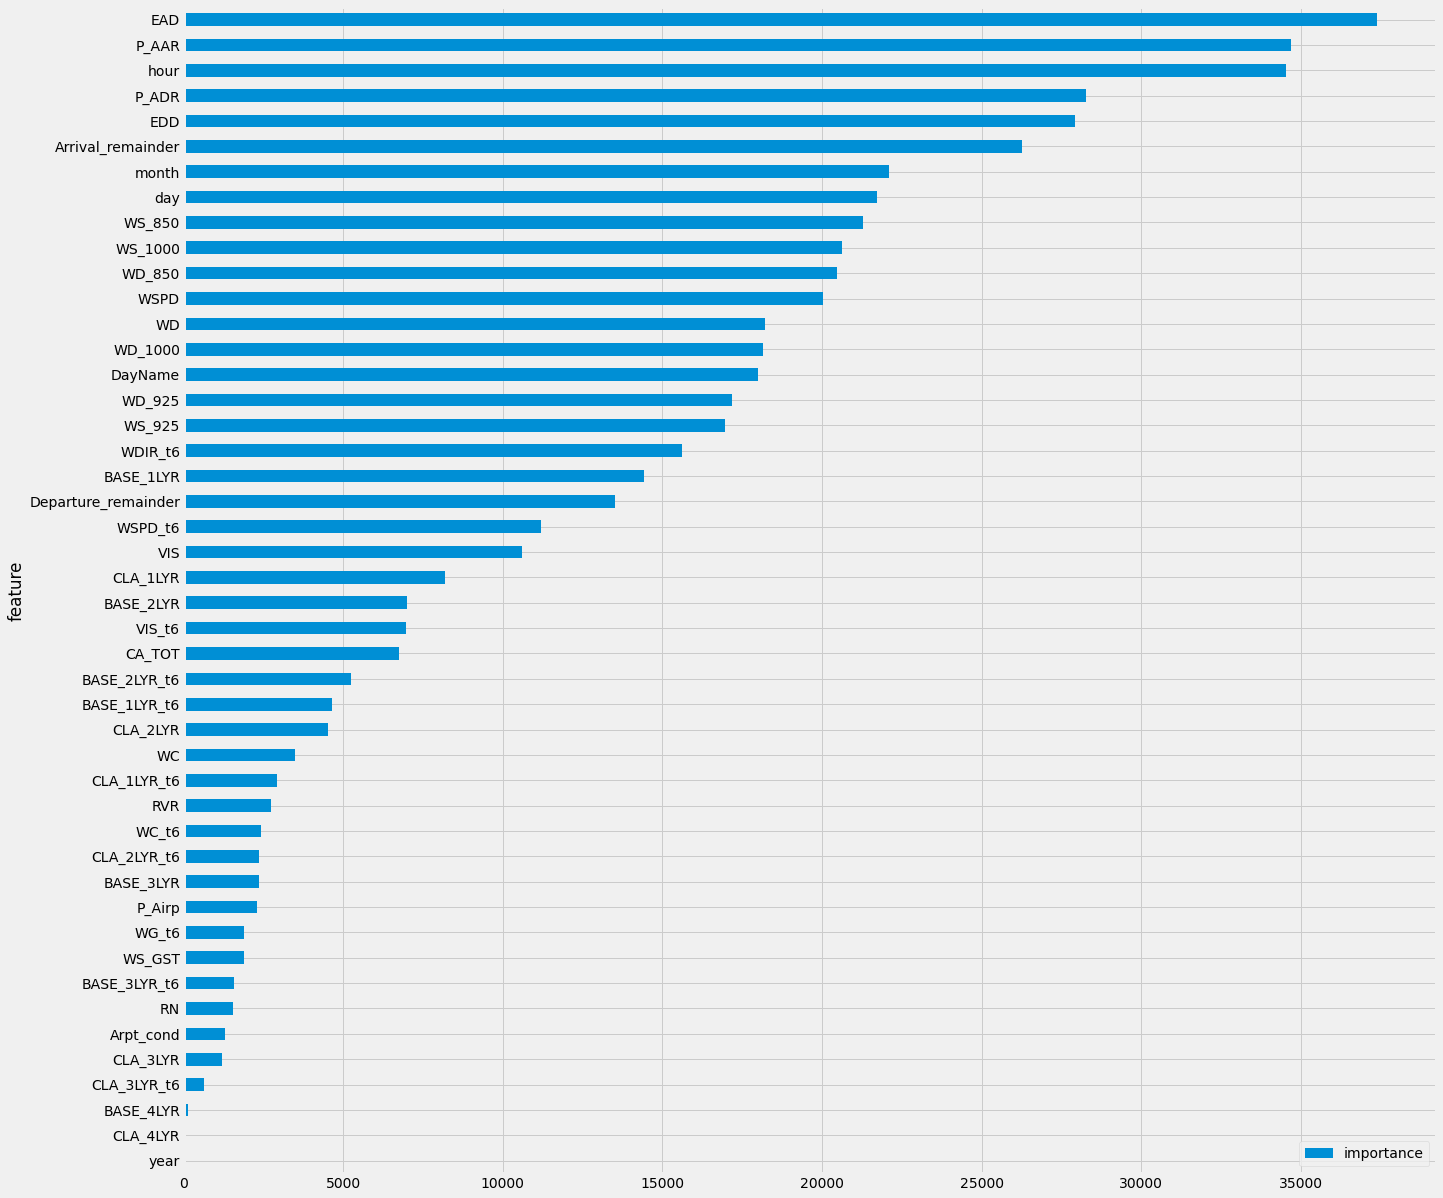

In [20]:
# Feature Importance
imp = pd.DataFrame({'feature': Data_m.columns, 'importance': reg_arrival.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh', figsize = (20,20))
plt.legend(loc='lower right')

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l2'>

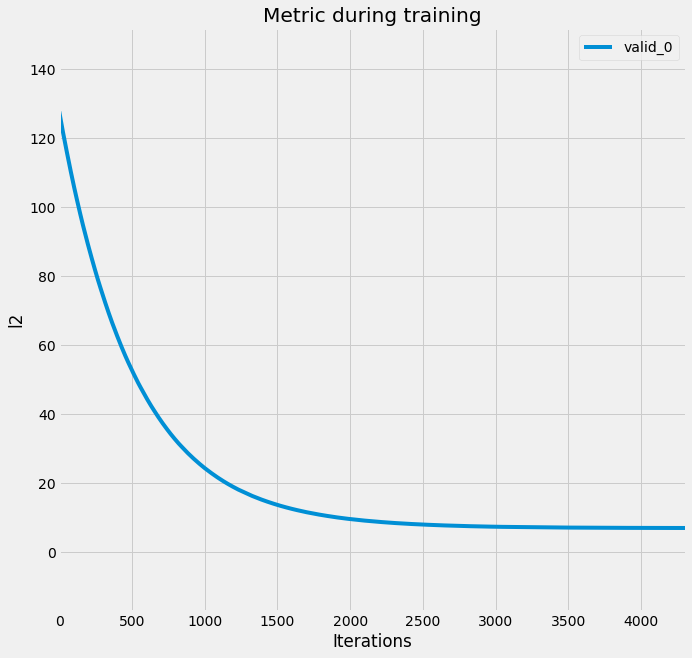

In [26]:
plot_metric(reg_arrival, figsize=(10,10))

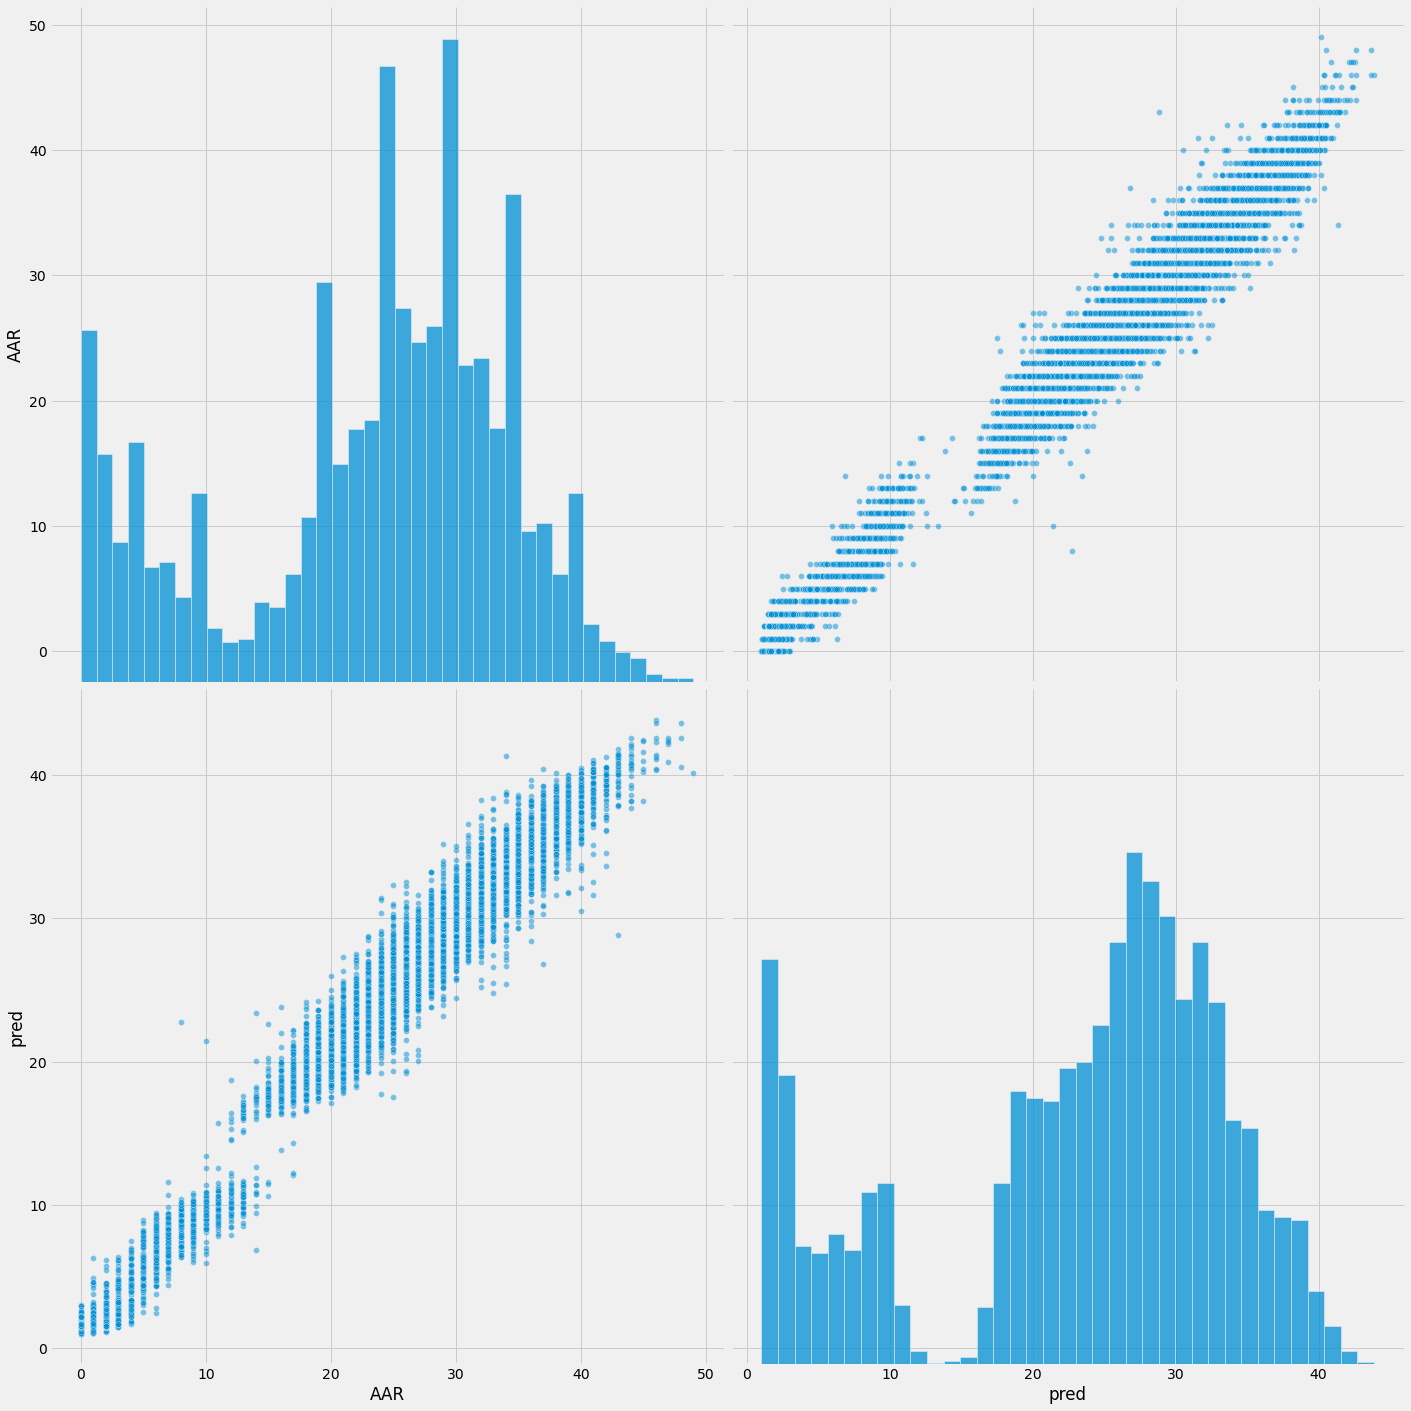

In [23]:
# AAR - pred
pred_test_a = Data_raw.drop('ADR', axis=1)
pred_test_a['pred'] = reg_arrival.predict(pred_test_a.drop('AAR', axis=1))
sns.pairplot(data=pred_test_a, vars=['AAR','pred'], size=10, plot_kws={'alpha': .5})

In [27]:
# Test
Test_all = Test(Data_raw, ops='arrival', start = 0, end = 8760).sort_values('Difference')
Test_all['Difference'].abs().sort_values(ascending=False).head(30)

8241    14.760006
1098    14.198007
5769    11.441463
1317    10.217466
7543     9.498707
5985     9.413930
6904     9.404211
1481     8.848380
5086     8.551815
8717     8.483578
8742     8.374204
8730     8.221391
4883     7.855123
5260     7.791755
3824     7.634262
7623     7.565422
522      7.490538
6586     7.470743
4433     7.456414
3951     7.420761
5412     7.382371
3797     7.337470
7864     7.335848
254      7.290222
1094     7.279565
5245     7.219430
3134     7.176894
1103     7.172102
5721     6.955726
325      6.941220
Name: Difference, dtype: float64

-------------------
## Departure

In [24]:
# Predict & Evaluation
print(f'RMSE : {np.sqrt(mean_squared_error(y_train_d, reg_departure.predict(X_train_d))):.4f}')
print(f'Training R^2 : {r2_score(y_train_d, reg_departure.predict(X_train_d)) * 100:.4f}')
print(f'Test R^2 : {r2_score(y_test_d, reg_departure.predict(X_test_d)) * 100:.4f}')

RMSE : 1.3604
Training R^2 : 98.8085
Test R^2 : 95.3510


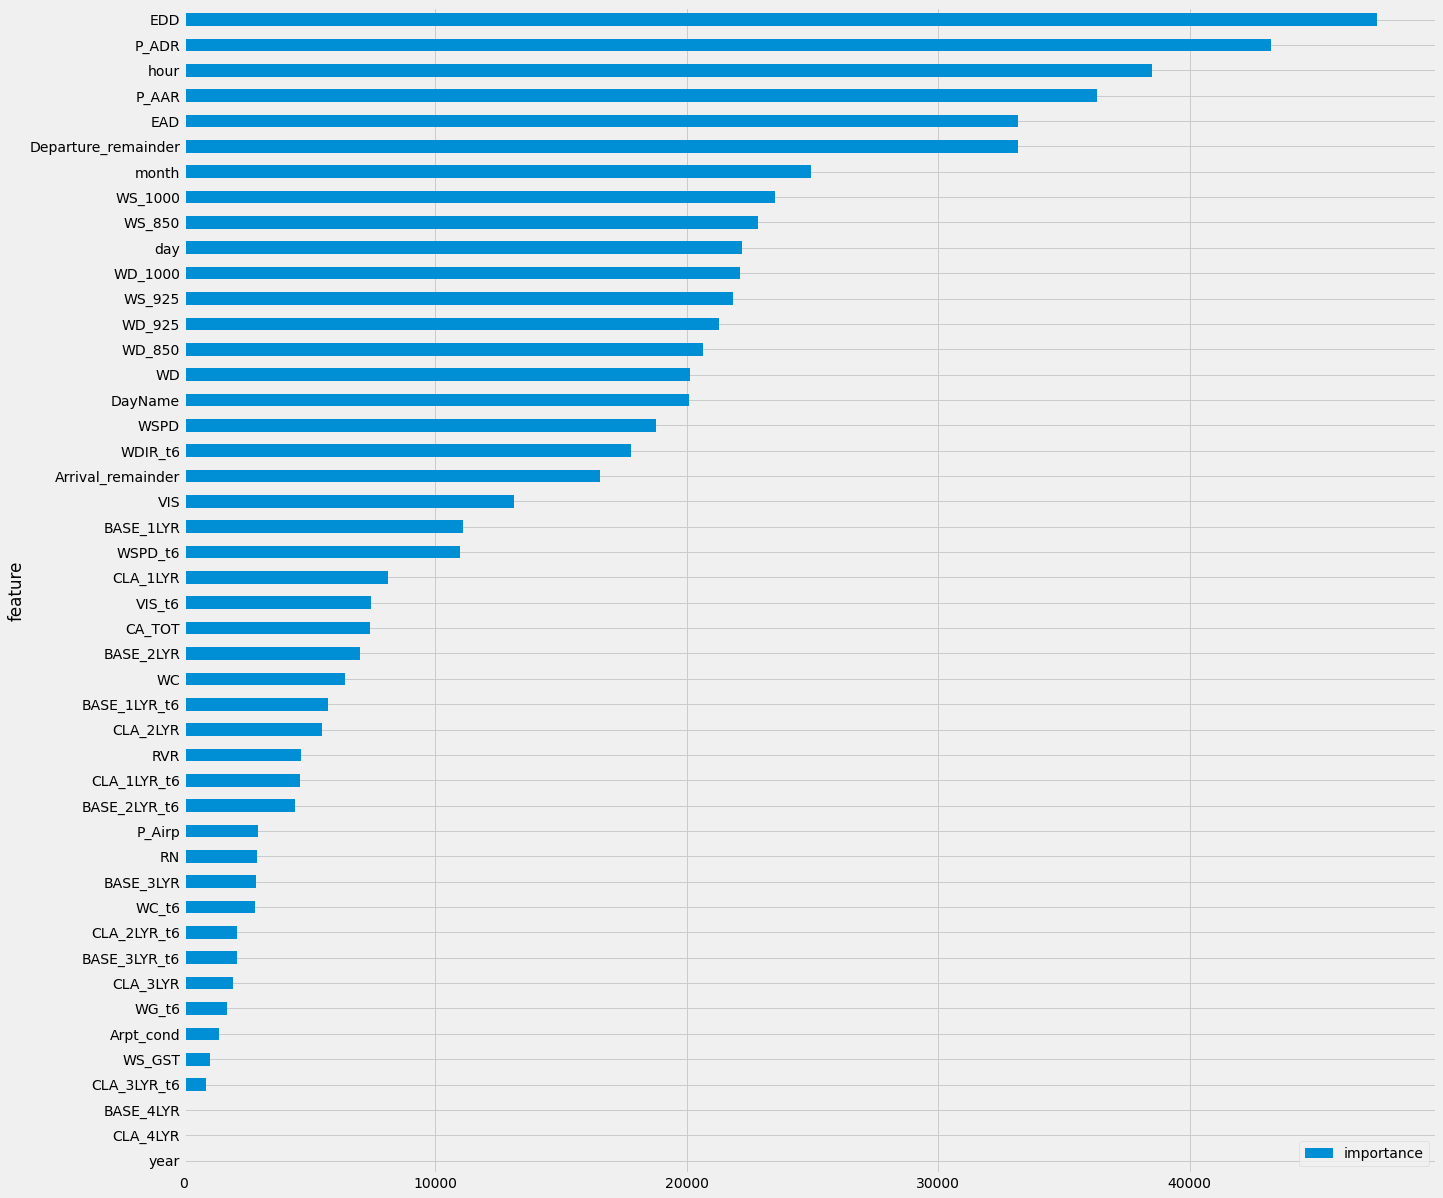

In [28]:
# Feature Importance
imp = pd.DataFrame({'feature': Data_m.columns, 'importance': reg_departure.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh', figsize = (20,20))
plt.legend(loc='lower right')

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l2'>

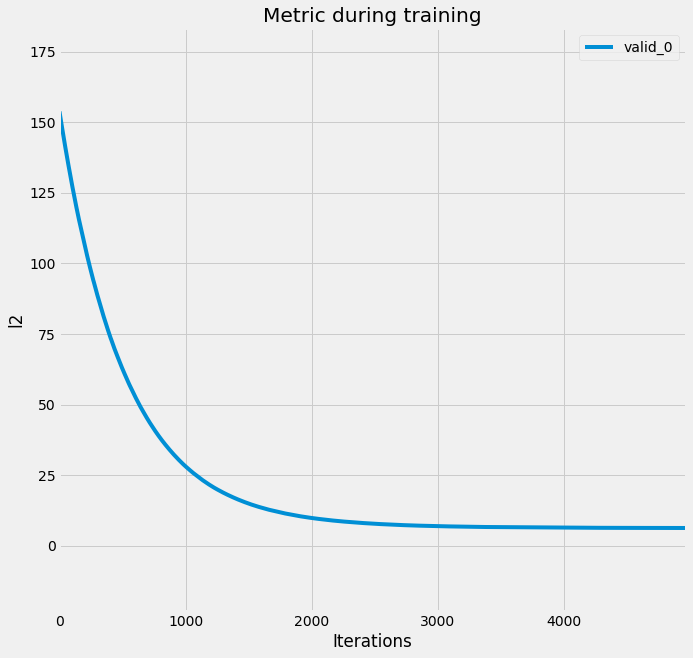

In [29]:
plot_metric(reg_departure, figsize=(10,10))

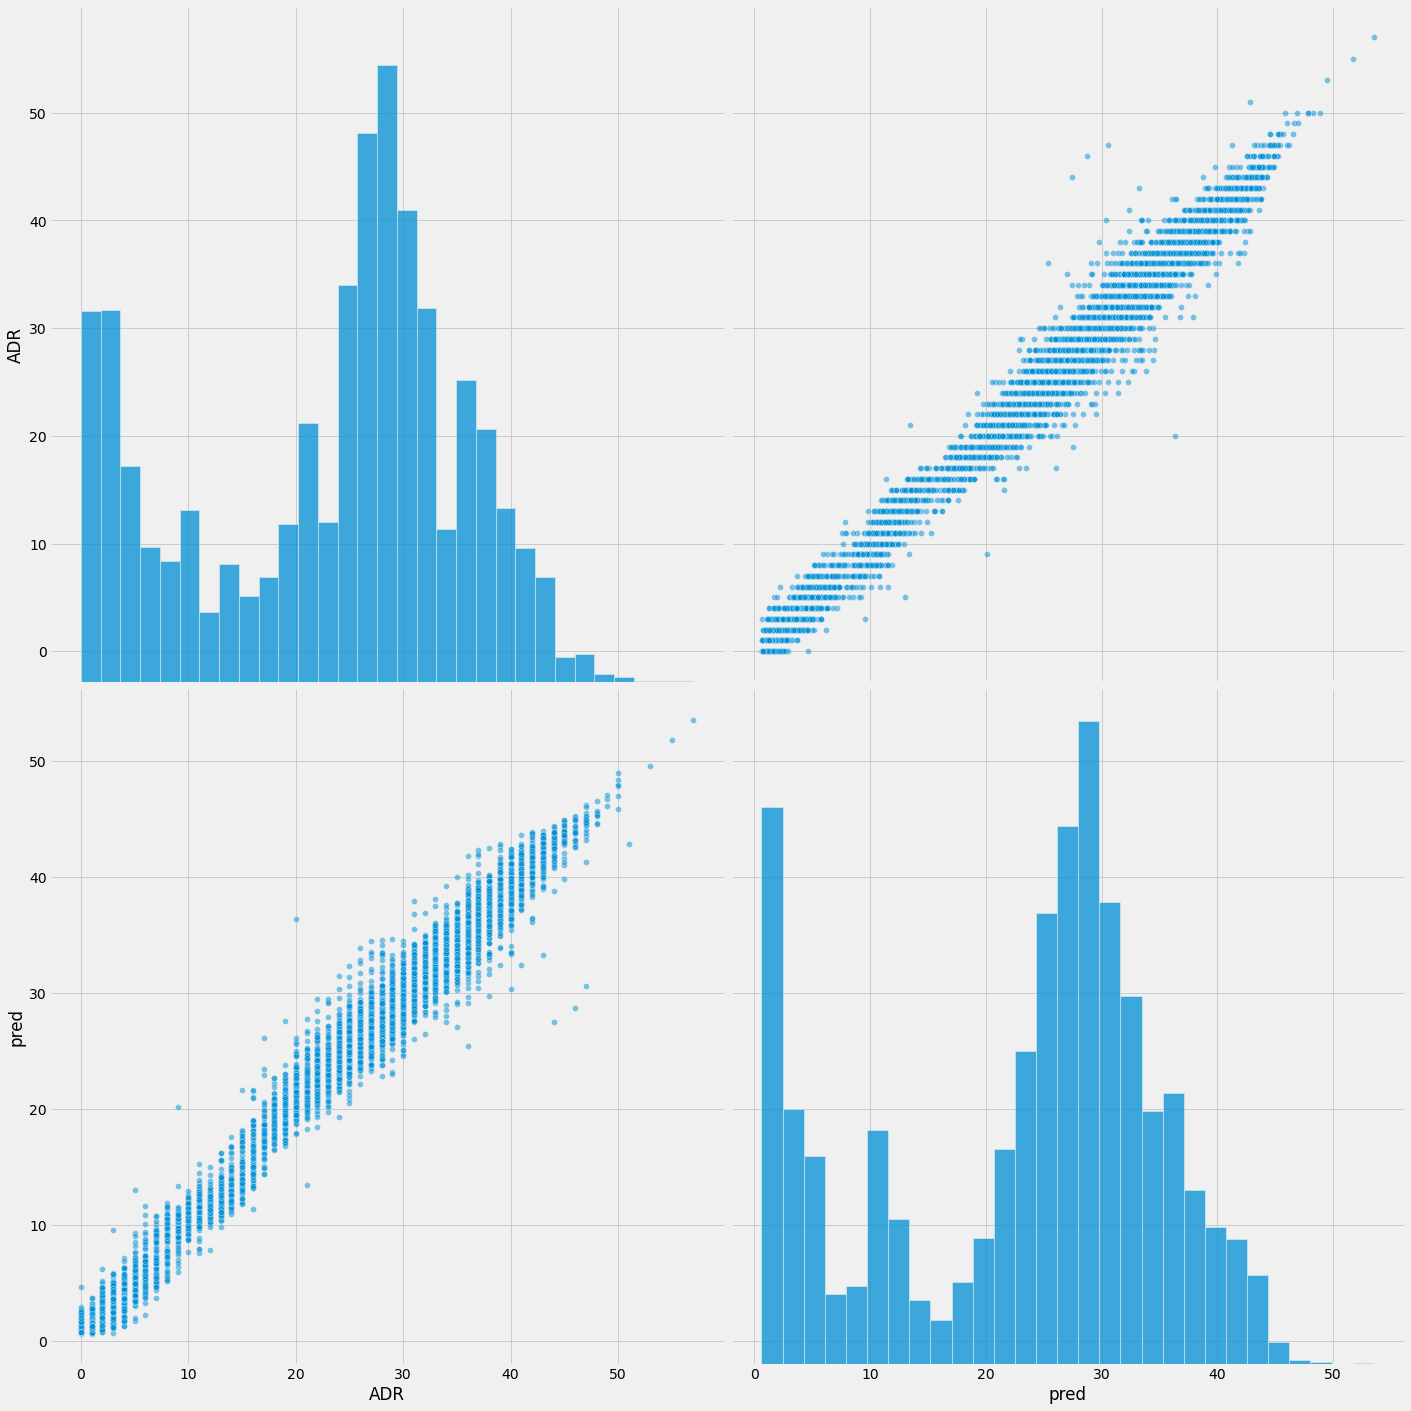

In [30]:
# ADR - pred
pred_test_d = Data_raw.drop('AAR', axis=1)
pred_test_d['pred'] = reg_departure.predict(pred_test_d.drop('ADR', axis=1))
sns.pairplot(data=pred_test_d, vars=['ADR','pred'], size=10, plot_kws={'alpha': .5})

In [31]:
# Test
Test_all = Test(Data_raw, ops='departure', start = 0, end = 8760).sort_values('Difference')
Test_all['Difference'].abs().sort_values(ascending=False).head(30)

5076    17.283155
5996    16.537319
5999    16.433877
5769    16.363451
8241    11.113710
7535    10.592011
2558     9.747238
4956     9.654218
2735     9.053211
8748     8.625843
6204     8.538513
5771     8.254514
2242     8.148452
4993     7.998499
5319     7.967457
5985     7.858384
5358     7.548288
1955     7.481271
325      7.466222
7142     7.418033
8603     7.319754
296      6.927689
2758     6.922592
2684     6.795629
311      6.685174
5100     6.636070
7292     6.629521
4070     6.616890
1183     6.601808
4820     6.594706
Name: Difference, dtype: float64

***
***
***

# Maximum Capacity

In [ ]:
# 예전 버전 : 원래 demand부터 시작 -> extra demand를 더함

def max_capacity(Data_raw, Data_m, example):   
    
    # extra
    extra_demand = 50
    
    # arrival
    data_a = Data_m.to_numpy()[example:example+1]
    XX_a = np.zeros((1,len(data_a.T)))
    for i in range(extra_demand+1):
        XX_a = np.append(XX_a, data_a, axis = 0)
        XX_a[i,0] = XX_a[i,0] + i-1
    XXX_a = XX_a[1:extra_demand+1]
    XXXX_a = np.arange(XXX_a[0,0], XXX_a[extra_demand-1,0]+1, 1)
    YYYY_a = reg_arrival.predict(XXX_a[0:extra_demand+1])
    max_aar = float(max(YYYY_a))
    actual_aar = int(Data_raw['AAR'][example:example+1])
    ead = int(Data_raw['EAD'][example:example+1])
    prediction_a = float(reg_arrival.predict(Data_m[example:example+1]))
    
    # departure
    data_d = Data_m.to_numpy()[example:example+1]
    XX_d = np.zeros((1,len(data_d.T)))
    for i in range(extra_demand+1):
        XX_d = np.append(XX_d, data_d, axis = 0)
        XX_d[i,2] = XX_d[i,2] + i-1
    XXX_d = XX_d[1:extra_demand+1]
    XXXX_d = np.arange(XXX_d[0,2], XXX_d[extra_demand-1,2]+1, 1)
    YYYY_d = reg_departure.predict(XXX_d[0:extra_demand+1])
    max_adr = float(max(YYYY_d))
    actual_adr = int(Data_raw['ADR'][example:example+1])
    edd = int(Data_raw['EDD'][example:example+1])
    prediction_d = float(reg_departure.predict(Data_m[example:example+1])) 

    # Total
    result_ = pd.DataFrame({'EAD' : XXXX_a ,'Predicted AAR' : YYYY_a, 'EDD' : XXXX_d ,'Predicted ADR' : YYYY_d, 
                            'Demand' : XXXX_a + YYYY_a, 'Capacity' : YYYY_a + YYYY_d})
    
    # plot
    plt.figure(figsize=(15,15))
    plt.title('Maximum Capacity', fontsize=30)
    plt.xlabel('Estimated Demands', fontsize=25)
    plt.ylabel('Capacity', fontsize=25)
    plt.plot(XXXX_a, YYYY_a, label = 'Arrival')
    plt.plot(XXXX_d, YYYY_d, label = 'Departure')
    plt.plot(XXXX_a[:-15]+XXXX_d[:-15], YYYY_a[:-15] + YYYY_d[:-15], label = 'Total')   # 안 예뻐서 뒤에 15개 자름
    plt.legend(prop={'size': 20})
    ax = plt.subplot()
    plt.text(0.95, 0.04,    # 위치조정
             f"""
             * Predicted Max AAR: {max_aar:.3f}\n
               Predicted AAR : {prediction_a:.3f}\n
               Actual AAR : {actual_aar} \n               
               EAD : {ead} \n\n
             
             * Predicted Max ADR: {max_adr:.3f}\n
               Predicted ADR : {prediction_d:.3f}\n
               Actual ADR : {actual_adr} \n               
               EDD : {edd} \n\n
             
             * Predicted Max Capacity: {max_aar + max_adr:.3f}\n
               Predicted Rate : {prediction_a + prediction_d:.3f}\n
               Actual Rate : {actual_aar + actual_adr} \n               
               Demand : {ead + edd}'
             """,
             fontsize=15, style='italic', transform=ax.transAxes, bbox={'facecolor': 'grey', 'alpha': 0, 'pad': 5})
    plt.show()    
    return result_

In [32]:

# training data에는 AAR, ADR 둘다 없어야 함
# 0부터 시작
# max capacity 선 추가
# 원래 demand에 대한 predict 점 추가

def max_capacity(Data_raw, Data_m, example):    # 50까지 늘림
    
    # extra
    demand = 75
    
    
    
    # arrival
    data_a = Data_m.to_numpy()[example:example+1]
    XX_a = np.zeros((1,len(data_a.T)))
    
    original_demand_a = int(data_a[0][0])
    for i in range(0,demand+1):
        XX_a = np.append(XX_a, data_a, axis = 0)
        XX_a[i,0] = XX_a[i,0] + i - original_demand_a
    
    XX_a[0] = XX_a[1]   
    XX_a[0,0] = 0   
    XXX_a = XX_a[0:demand+1]
    XXXX_a = np.arange(XXX_a[0,0], XXX_a[demand,0]+1, 1)
    YYYY_a = reg_arrival.predict(XXX_a[0:demand+1])
    max_aar = float(max(YYYY_a))
    actual_aar = int(Data_raw.drop('ADR', axis=1)['AAR'][example:example+1])
    ead = int(Data_raw.drop('ADR', axis=1)['EAD'][example:example+1])
    prediction_a = float(reg_arrival.predict(Data_m[example:example+1]))
    
    
    
    # departure
    data_d = Data_m.to_numpy()[example:example+1]
    XX_d = np.zeros((1,len(data_d.T)))
    
    original_demand_d = int(data_d[0][1])
    for i in range(0,demand+1):
        XX_d = np.append(XX_d, data_d, axis = 0)
        XX_d[i,1] = XX_d[i,1] + i - original_demand_d
        
    XX_d[0] = XX_d[1]           
    XX_d[0,1] = 0
    XXX_d = XX_d[0:demand+1]
    XXXX_d = np.arange(XXX_d[0,1], XXX_d[demand,1]+1, 1)
    YYYY_d = reg_departure.predict(XXX_d[0:demand+1])
    max_adr = float(max(YYYY_d))
    actual_adr = int(Data_raw.drop('AAR', axis=1)['ADR'][example:example+1])
    edd = int(Data_raw.drop('AAR', axis=1)['EDD'][example:example+1])
    prediction_d = float(reg_departure.predict(Data_m[example:example+1])) 

    
    
    # capacity - arrival과 departure을 수요의 비율로 늘렸을 때
    max_cap = int(max(Data_raw['AAR'] + Data_raw['ADR']))
    max_capacity = np.zeros(demand+1)
    for i in range(0,demand*2+1,2):
        if round(i*data_a[0,0]/(data_a[0,0]+data_d[0,1])) >=75:
            capa_arr = YYYY_a[75]
        elif round(i*data_d[0,1]/(data_a[0,0]+data_d[0,1])) >=75:
            capa_dep = YYYY_d[75]
        else:
            capa_arr = YYYY_a[round(i*data_a[0,0]/(data_a[0,0]+data_d[0,1]))]
            capa_dep = YYYY_d[round(i*data_d[0,1]/(data_a[0,0]+data_d[0,1]))]
        max_capacity[int(i/2)] = capa_arr + capa_dep
    
    
    
    # Total
    #result_ = pd.DataFrame({'EAD' : XXXX_a ,'Predicted AAR' : YYYY_a, 
    #                        'EDD' : XXXX_d ,'Predicted ADR' : YYYY_d, 
    #                        'Demand' : XXXX_a + YYYY_a, 'Capacity' : YYYY_a + YYYY_d})
    
    
    
    # plot
    plt.figure(figsize=(15,15))
    plt.title('Maximum Capacity', fontsize=30)
    plt.xlabel('Estimated Demands', fontsize=25)
    plt.ylabel('Capacity', fontsize=25)
    
    plt.plot(XXXX_a, YYYY_a, label = 'Arrival')    # Arrival
    plt.plot(XXXX_d, YYYY_d, label = 'Departure')    # Departure
    plt.plot(XXXX_a[:-5] + XXXX_d[:-5], max_capacity[:-5], label = 'Total')    # Capacity - 안 예뻐서 뒤에 15개 자름
    plt.plot(XXXX_a[:-5]+XXXX_d[:-5], [max_cap]*(demand-4), label = f'Maximum Data : {max_cap}')    # 데이터 상 max capacity
    
    plt.plot(data_a[0,0], prediction_a,'ob', markersize = 10)    # 원래 arrival 예측값
    plt.plot(data_d[0,1], prediction_d,'or', markersize = 10)    # 원래 departure 예측값
    plt.plot(data_a[0,0]+data_d[0,1], prediction_a + prediction_d,'yo', markersize = 15)    # 원래 capacity 예측값
    
    plt.legend(prop={'size': 20}, loc = 'upper left')
    
    ax = plt.subplot()
    
    plt.text(0.95, 0.04,    # 위치조정
             f"""
             * Predicted Max AAR: {max_aar:.3f}\n
               Predicted AAR : {prediction_a:.3f}\n
               Actual AAR : {actual_aar} \n               
               EAD : {ead} \n\n
             
             * Predicted Max ADR: {max_adr:.3f}\n
               Predicted ADR : {prediction_d:.3f}\n
               Actual ADR : {actual_adr} \n               
               EDD : {edd} \n\n
             
             * Predicted Max Capacity: {max_aar + max_adr:.3f}\n
               Predicted Rate : {prediction_a + prediction_d:.3f}\n
               Actual Rate : {actual_aar + actual_adr} \n               
               Demand : {ead + edd}'
             """,
             fontsize=15, style='italic', transform=ax.transAxes, bbox={'facecolor': 'grey', 'alpha': 0, 'pad': 5})
    plt.show()   
    
    
    
    return    #result_

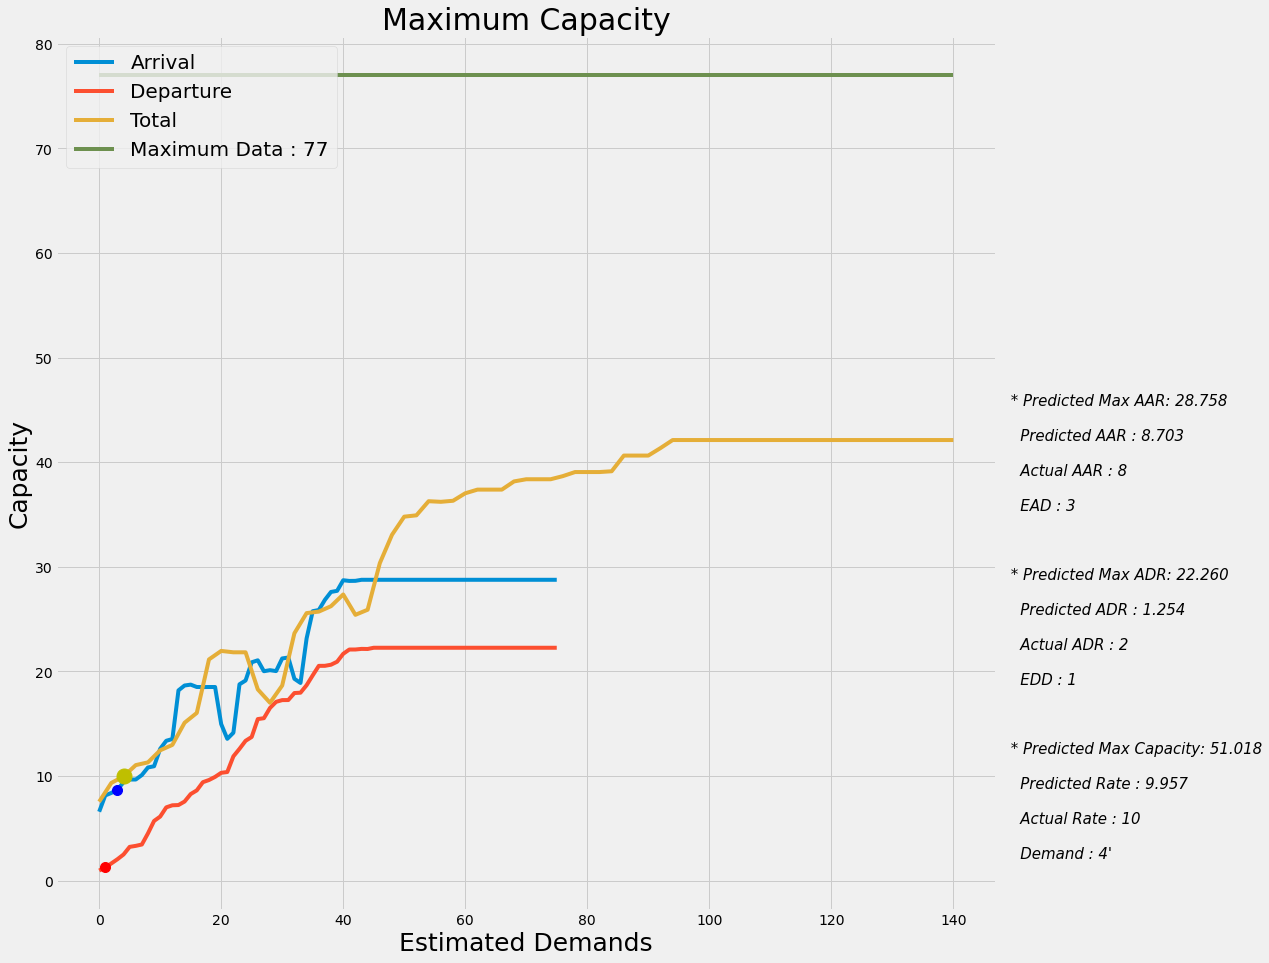

In [33]:
# 원하는 시간의 Max Capacity 그래프

max_capacity(Data_raw, Data_m, 1755)     # 숫자에 원하는 data번호 넣기

< Notable Samples> 

* pd.DataFrame(Data_raw).idxmax()             # 각 column별 max값의 index

AAR 최소 : 2 <br>
AAR 최대 : 1481 <br>
EAD 최대 : 641 <br>
ADR 최소 : 28 <br>
ADR 최대 : 538 <br>
EDD 최대 : 273 <br>
Total Rate(AAR+ADR) 최대(77) : 5703 <br>
Total Demand(EAD+EDD) 최대(70) : 4814 <br><br>

Arrival_reaminder 최대 : 5992 <br>
Departure_remainder 최대 : 8242 <br><br>

WSPD 최대 : 5990 <br>
W_GST 최대 : 5990 <br>
시정 최소 : 1755 <br>
Ceiling 최소 : 321 <br>
RVR 최소 1448 <br><br>

TAF WSPD 최대 : 5988 <br>
TAF W_GST 최대 : 5988 <br>
TAF 시정 최소 : 319 <br>
TAF Ceiling 최소 : 10?? <br>
<br>
<br>
* Max capacity에 영향을 주는 것 <br>
1. 관제사 워크로드 <br>
2. 기상 <br>
3. 항공기 성능(어떤 어프로치 가능한지 등) <br>


In [ ]:
# Data : 불러온 파일
# Data_temp : 일단 필요 없어 보이는 column을 버린 것
# data_taf : dictinoary 안에 Data_6 - Data_24 전부 넣은 것
# Data_6, Data_12 .. : 해당 시간 전의 TAF만 있고, 나머지 시간의 TAF는 버린 것
# Data_raw : Data_#과 동일
# Data_m : Data_# 에서 AAR, ADR 뺀 것
# Data_a : Data_m 로 바꿈
# Data_d : Data_m 로 바꿈

***
***
***

# 추가 실험

##  왜?

In [ ]:
Data['AAR'].value_counts()

In [ ]:
pred = pd.DataFrame({'pred' :reg_arrival.predict(Data_a)})
print('9. : ', pred[(pred['pred'] < 10) & (pred['pred'] >= 9)].shape)
print('10. : ', pred[(pred['pred'] < 11) & (pred['pred'] >= 10)].shape)
print('11. : ', pred[(pred['pred'] < 12) & (pred['pred'] >= 11)].shape)
print('12. : ', pred[(pred['pred'] < 13) & (pred['pred'] >= 12)].shape,'*')
print('13. : ', pred[(pred['pred'] < 14) & (pred['pred'] >= 13)].shape,'*')
print('14. : ', pred[(pred['pred'] < 15) & (pred['pred'] >= 14)].shape,'*')
print('15. : ', pred[(pred['pred'] < 16) & (pred['pred'] >= 15)].shape,'*')
print('16. : ', pred[(pred['pred'] < 17) & (pred['pred'] >= 16)].shape)
print('17. : ', pred[(pred['pred'] < 18) & (pred['pred'] >= 17)].shape)

In [ ]:
sssss = pred[(pred['pred'] < 16) & (pred['pred'] >= 12)].index
Data.loc[sssss]

In [ ]:
ddddd = Data[(Data['AAR'] >= 12)&(Data['AAR']<15)].index

DD = Data[(Data['AAR'] >= 12)&(Data['AAR']<=16)]
DDDD = pred.loc[ddddd].join(DD).head(30)

In [ ]:
sns.pairplot(data=DDDD, vars=['AAR','pred'], size=6, plot_kws={'alpha': 1})

In [ ]:
DDDD.describe()

In [ ]:
fea = 'WD'

sns.distplot(DDDD[fea])

print("AAR Skewness: %f" % Data[fea].skew())
print("ADR Kurtosis: %f" % Data[fea].kurt())

# P_Airp Arrival_remainder

***
***
***

# 모델 완성 후 할 일

* data.py / training.py / evaluation.py 등 이렇게 나누기

***
***
***

# 모델 저장

In [ ]:
import joblib

lgbr_a = "../test/lgbr_a.pkl"
lgbr_d = "../test/lgbr_d.pkl"
joblib.dump(reg_arrival, lgbr_a)
joblib.dump(reg_departure, lgbr_d)